In [1]:
%load_ext autoreload
%autoreload

In [2]:
from utils_v1 import *


In [3]:
from icecream import ic
import pdb
from sklearn import metrics
import importlib
import utils_v1
import tracemalloc
import sys
import numpy as np
from src.dataset import (
    MultipleDates,
    PAMultipleDates,
    MTMultipleDates,
    MAMultipleDates,
    MSMultipleDates,
    PIMultipleDates,
    MOMultipleDates,
    L8MTMultipleDates,
    L8AMMultipleDates
)

# from src.dataset_legacy import MTDeforestationTime
from src import training_generator as generator
from src.patchesHandler import PatchesHandler, PatchesHandlerMultipleDates
from src.manager.multioutput import ManagerMCDropout, ManagerSingleRun, ManagerEnsemble, ManagerEvidential2
from src.Logger import Logger
import src.rasterTools as rasterTools



Tensorflow ver. 2.6.0


In [4]:
ic.configureOutput(includeContext=True)

In [5]:
useLessInferenceRuns = False
reducedInferenceRuns = 30

In [6]:
config = {
	"training": False,
	"inferring": True,
	"site": "PI", # values: MT, PA, MS, PI, L8MT, L8AM
	"training_date": "earlier", # values: earlier, current
	"mode": "ensemble", # values: mcd, single_run, ensemble, evidential2
	"uncertainty_method": "pred_entropy", # pred_var MI pred_entropy KL pred_entropy_single
	"loadInference": False,
	"removePolygons": True,
	"plotLandsat": False,
	"plotPOI": False,

	"save_probabilities": False,
	"addPastDeforestationInput": True,
	"classes_mode": False,																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																																						
	"learning_rate": 1e-4,
    "use_cloud_mask": False,
    "mask_out_non_biome": True,
	# "mask_out_no_data": True


	"georreferenced_save": True,
	"drop_no_data_pixels": False,
	"use_entire_image_as_training": False

}

In [7]:



if config['mode'] == 'mcd':
	managerClass = ManagerMCDropout
	config['inference_times'] = 10
	config['training_times'] = 1
elif config['mode'] == 'single_run':
	managerClass = ManagerSingleRun
	config['inference_times'] = 1
	config['training_times'] = 1
	config['uncertainty_method'] = 'pred_entropy_single'
elif config['mode'] == 'ensemble':
	managerClass = ManagerEnsemble
	config['inference_times'] = 10
	config['training_times'] = 10
elif config['mode'] == 'evidential2':
	managerClass = ManagerEvidential2
	config['inference_times'] = 1
	config['training_times'] = 1
else:
	raise ValueError('Invalid mode')

print(config)

if config['site'] == 'PA':
	if config['training'] == True and config['training_date'] == 'earlier':
		dates = [2017, 2018]
	else:
		dates = [2018, 2019]
	datasetClass = PAMultipleDates
elif config['site'] == 'MT':
	if config['training'] == True and config['training_date'] == 'earlier':
		dates = [2018, 2019]
	else:
		dates = [2019, 2020]
	datasetClass = MTMultipleDates
elif config['site'] == 'MS':
	if config['training'] == True and config['training_date'] == 'earlier':
		dates = [2018, 2019]
		# dates = [2019, 2020]

	else:
		dates = [2019, 2020]
		# dates = [2020, 2021]

	datasetClass = MSMultipleDates
elif config['site'] == 'PI':
	if config['training'] == True and config['training_date'] == 'earlier':
		dates = [2018, 2019]
		# dates = [2017, 2018]

	else:
		dates = [2019, 2020]
		# dates = [2018, 2019]

	datasetClass = PIMultipleDates
	config['mask_out_non_biome'] = True
elif config['site'] == 'MO':
	if config['training'] == True and config['training_date'] == 'earlier':
		dates = [2018, 2019]
	else:
		dates = [2019, 2020]
	datasetClass = MOMultipleDates
elif config['site'] == 'L8MT':
	if config['training'] == True and config['training_date'] == 'earlier':
		dates = [2021, 2022]
	else:
		dates = [2022, 2023]
		# dates = [2021, 2022]
	datasetClass = L8MTMultipleDates
elif config['site'] == 'L8AM':
	if config['training'] == True and config['training_date'] == 'earlier':
		dates = [2021, 2022]
	else:
		dates = [2022, 2023]
	datasetClass = L8AMMultipleDates

else:
	raise ValueError('Invalid site')

dataset = datasetClass(config = config,
			   dates = dates, 
	 	addPastDeforestationInput = config['addPastDeforestationInput'],
		borderBuffer = 2)	

if issubclass(type(dataset), MultipleDates):
	patchesHandler = PatchesHandlerMultipleDates(
		dataset)
else:
	patchesHandler = PatchesHandler()



if config['training'] == False:

	if type(dataset) == PAMultipleDates:


		if config['training_date'] == 'current': exp = 0; repetition_id = 0
		elif config['training_date'] == 'earlier': 
			exp = 1; repetition_id = 0
			# exp = 20; repetition_id = 0
		 
	elif type(dataset) == MTMultipleDates:
		
		if config['training_date'] == 'current': exp = 2; repetition_id = 8
		elif config['training_date'] == 'earlier': exp = 3; repetition_id = 6		

	elif type(dataset) == MSMultipleDates:

		if config['training_date'] == 'current': exp = 40; repetition_id = 0
		elif config['training_date'] == 'earlier': 
			# exp = 5; repetition_id = 0		
			# exp = 24; repetition_id = 0	
			# exp = 30; repetition_id = 0	# L1C
			exp = 37; repetition_id = 0	# L1C (New)
			
	elif type(dataset) == PIMultipleDates:

		if config['training_date'] == 'current': exp = 44; repetition_id = 0
		elif config['training_date'] == 'earlier': 
			exp = 7; repetition_id = 0	
			## exp = 18; repetition_id = 0	
			exp = 27; repetition_id = 0 # L1C
			# exp = 28; repetition_id = 0 # L1C 2020
	elif type(dataset) == MOMultipleDates:

		if config['training_date'] == 'current': exp = 6; repetition_id = 0
		elif config['training_date'] == 'earlier': 
			exp = 7; repetition_id = 0	
			exp = 19; repetition_id = 0	
	elif type(dataset) == L8MTMultipleDates:

		if config['training_date'] == 'current': exp = 38; repetition_id = 0
		elif config['training_date'] == 'earlier': 
			
			exp = 38; repetition_id = 0	
	elif type(dataset) == L8AMMultipleDates:

		if config['training_date'] == 'current': exp = 38; repetition_id = 0
		elif config['training_date'] == 'earlier': 
			
			exp = 39; repetition_id = 0	

else:

	exp = 45
	repetition_id = 0
	
logger = Logger()
manager = managerClass(config, dataset, patchesHandler, logger)
manager.defineExperiment(exp)


{'training': False, 'inferring': True, 'site': 'PI', 'training_date': 'earlier', 'mode': 'ensemble', 'uncertainty_method': 'pred_entropy', 'loadInference': False, 'removePolygons': True, 'plotLandsat': False, 'plotPOI': False, 'save_probabilities': False, 'addPastDeforestationInput': True, 'classes_mode': False, 'learning_rate': 0.0001, 'use_cloud_mask': False, 'mask_out_non_biome': True, 'georreferenced_save': True, 'drop_no_data_pixels': False, 'use_entire_image_as_training': False, 'inference_times': 10, 'training_times': 10}


ic| dataset.py:608 in __init__()- list(self.date_ids): [0]
ic| dataset.py:629 in __init__()
    self.image_channels: [[0, 1, 2, 3, 4, 5, 6, 7, 8]]
ic| patchesHandler.py:166 in __init__()- self.input_image_shape: 9
ic| patchesHandler.py:167 in __init__()
    self.dataset.image_channels: [[0, 1, 2, 3, 4, 5, 6, 7, 8]]


In [8]:
'''
import src.Logger as lg
importlib.reload(lg)
logger = Logger()
manager.logger = logger
'''

'\nimport src.Logger as lg\nimportlib.reload(lg)\nlogger = Logger()\nmanager.logger = logger\n'

In [9]:
dates

[2019, 2020]

In [10]:
manager.config

{'training': False,
 'inferring': True,
 'site': 'PI',
 'training_date': 'earlier',
 'mode': 'ensemble',
 'uncertainty_method': 'pred_entropy',
 'loadInference': False,
 'removePolygons': True,
 'plotLandsat': False,
 'plotPOI': False,
 'save_probabilities': False,
 'addPastDeforestationInput': True,
 'classes_mode': False,
 'learning_rate': 0.0001,
 'use_cloud_mask': False,
 'mask_out_non_biome': True,
 'georreferenced_save': True,
 'drop_no_data_pixels': False,
 'use_entire_image_as_training': False,
 'inference_times': 10,
 'training_times': 10,
 'dropout_training': False}

In [11]:
exp

27

In [12]:
manager.setExperimentPath()
manager.createLogFolders()

In [13]:
# ic(type(dataset), exp, dataset.dates)


In [14]:

manager.loadLabel()

D:/Jorge/datasets/deforestation/PI/deforestation_past_years.tif
Loaded deforestation past years


ic| dataset.py:706 in loadLabelFromDate()
    np.unique(deforestation_past_years, return_counts=True): (array([   0, 2002, 2004, 2006, 2008, 2010, 2012, 2013, 2014, 2015, 2016,
                                                                    2017, 2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([340580606,   4312043,   6953620,   5659916,   7162776,   6261432,
                                                                      8191420,   3233962,   3270293,   3044419,   1817289,   2359424,
                                                                      2201926,   3050229,   2901307,   2418575], dtype=int64))


Label where deforestation past years is actual date (2020) = 1


ic| dataset.py:709 in loadLabelFromDate()
    np.unique(deforestation_past_years, return_counts=True): (array([   0, 2002, 2004, 2006, 2008, 2010, 2012, 2013, 2014, 2015, 2016,
                                                                    2017, 2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([340580606,   4312043,   6953620,   5659916,   7162776,   6261432,
                                                                      8191420,   3233962,   3270293,   3044419,   1817289,   2359424,
                                                                      2201926,   3050229,   2901307,   2418575], dtype=int64))


Past deforestation different from 0 (no deforestation)


ic| dataset.py:713 in loadLabelFromDate()
    np.unique(deforestation_past_years, return_counts=True): (array([   0, 2002, 2004, 2006, 2008, 2010, 2012, 2013, 2014, 2015, 2016,
                                                                    2017, 2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([340580606,   4312043,   6953620,   5659916,   7162776,   6261432,
                                                                      8191420,   3233962,   3270293,   3044419,   1817289,   2359424,
                                                                      2201926,   3050229,   2901307,   2418575], dtype=int64))


Past deforestation before 2008 is 2
D:/Jorge/datasets/deforestation/PI/deforestation_before_2000_PI.tif


ic| dataset.py:717 in loadLabelFromDate()
    np.unique(label_past_deforestation_before_2008, return_counts=True): (array([  0, 208], dtype=uint8), array([385251297,  18167940], dtype=int64))
ic| dataset.py:719 in loadLabelFromDate()
    np.unique(deforestation_past_years, return_counts=True): (array([   0, 2002, 2004, 2006, 2008, 2010, 2012, 2013, 2014, 2015, 2016,
                                                                    2017, 2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([340580606,   4312043,   6953620,   5659916,   7162776,   6261432,
                                                                      8191420,   3233962,   3270293,   3044419,   1817289,   2359424,
                                                                      2201926,   3050229,   2901307,   2418575], dtype=int64))


D:/Jorge/datasets/sentinel2/PI/biome_limits.tif


ic| dataset.py:698 in loadLabel()
    label_per_date.shape: (19357, 20841, 1)


Removing bufer................
Mask label shape:  
 (19357, 20841, 1) 
 Unique values:  
 [0 1 2]


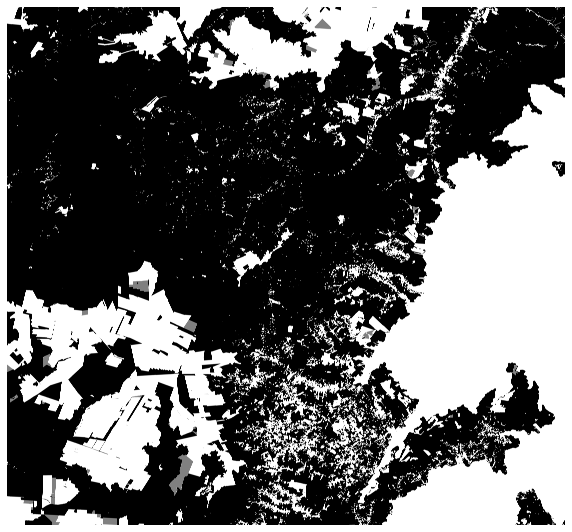

In [15]:
manager.logger.plotFigure(manager.label_mask, 
    name='image_stack_first_channel', cmap=plt.cm.gray, savefig=False, figsize=(10,10))

In [16]:

# Creating tile mask
manager.createTrainValTestTiles()


Tiles size:  3871 4168
Mask size:  (19355, 20840)


In [17]:
def get_pixel_count_set(label, mask, set_id):
    label_set = label[mask == set_id]
    return np.unique(label_set, return_counts=True)


In [18]:

np.unique(manager.mask_tiles)
for set_id in np.unique(manager.mask_tiles):
    print('Set', set_id, get_pixel_count_set(manager.label_mask, manager.mask_tiles, set_id))


Set 1 (array([0, 1, 2], dtype=uint8), array([15026357,     5040,  1102931], dtype=int64))
Set 2 (array([0, 1, 2], dtype=uint8), array([11192159,    82356,  4859813], dtype=int64))
Set 3 (array([0, 1, 2], dtype=uint8), array([7554008,  344113, 8236207], dtype=int64))
Set 4 (array([0, 1, 2], dtype=uint8), array([10336883,   106591,  5690854], dtype=int64))
Set 5 (array([0, 1, 2], dtype=uint8), array([14238361,    15129,  1880838], dtype=int64))
Set 6 (array([0, 1, 2], dtype=uint8), array([15878629,     2003,   253696], dtype=int64))
Set 7 (array([0, 1, 2], dtype=uint8), array([15744820,    17571,   371937], dtype=int64))
Set 8 (array([0, 1, 2], dtype=uint8), array([15459981,    23044,   651303], dtype=int64))
Set 9 (array([0, 1, 2], dtype=uint8), array([13799850,    91834,  2242644], dtype=int64))
Set 10 (array([0, 1, 2], dtype=uint8), array([ 4314565,      467, 11819296], dtype=int64))
Set 11 (array([0, 1, 2], dtype=uint8), array([14118799,    37635,  1977894], dtype=int64))
Set 12 (arr

In [19]:

manager.label_mask.dtype

dtype('uint8')

In [20]:

manager.getLabelCurrentDeforestation()

In [21]:

manager.loadInputImage()

ic| dataset.py:649 in loadInputImage()
    image_stack.shape: (19357, 20841, 9)


Image shape:  (19357, 20841, 9)
mask:  (19355, 20840)
image stack:  (19355, 20840, 9)
ref : (19355, 20840, 1)


In [22]:
if config['drop_no_data_pixels'] == True:
    manager.maskNoDataAsNotConsideredClass()

In [23]:
manager.dataset.previewBandsSnip

[[1, 2, 3], [5, 6, 7]]

In [24]:
condition = np.squeeze(np.zeros_like(manager.label_mask))


In [25]:
condition.shape

(19355, 20840)

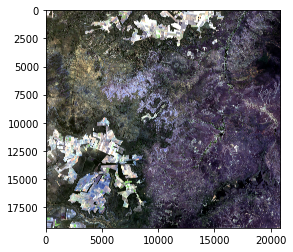

In [26]:
plt.imshow(manager.image_stack[...,[3,2,1]])

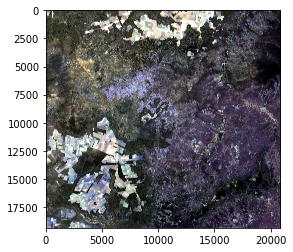

In [27]:
plt.imshow(manager.image_stack[...,[7,6,5]])

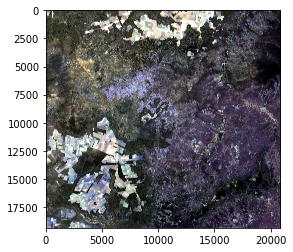

In [28]:
plt.imshow(manager.image_stack[...,[7,6,5]])

In [29]:

np.unique(manager.image_stack[...,0], return_counts=True)

(array([0.        , 0.05263158, 0.10526316, 0.15789473, 0.21052632,
        0.2631579 , 0.31578946, 0.36842105, 0.42105263, 0.5263158 ,
        0.6315789 , 0.7368421 , 0.84210527, 0.94736844, 1.        ],
       dtype=float32),
 array([327681867,   3049737,   2201856,   2359401,   1817235,   3044355,
          3270027,   3233918,   8191217,   6258301,   7162448,   5659195,
          6953190,   4309946,  18165507], dtype=int64))

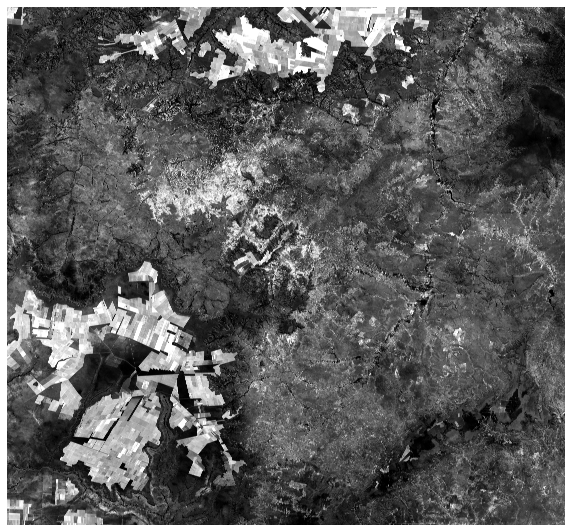

In [30]:

manager.logger.plotFigure(manager.image_stack[...,1], 
    name='image_stack_first_channel', cmap=plt.cm.gray, savefig=False, figsize=(10,10))

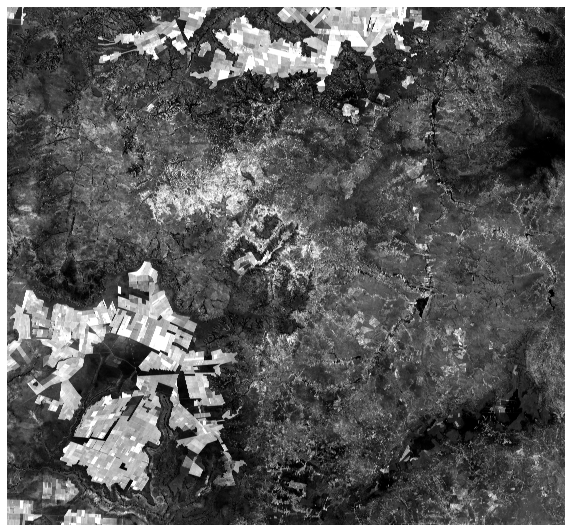

In [31]:

manager.logger.plotFigure(manager.image_stack[...,5], 
    name='image_stack_first_channel', cmap=plt.cm.gray, savefig=False, figsize=(10,10))

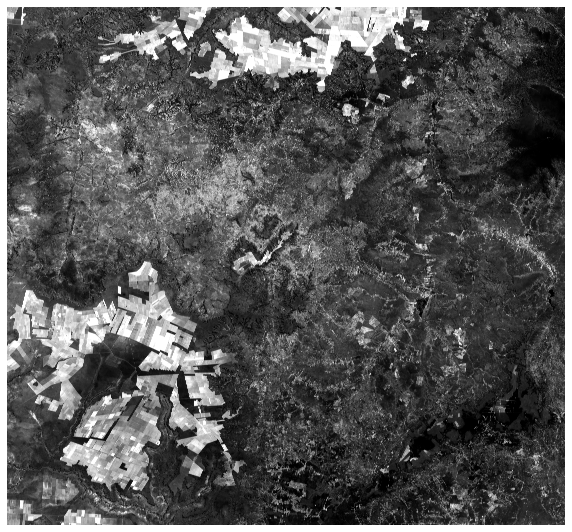

In [32]:

manager.logger.plotFigure(manager.image_stack[...,-3], 
    name='image_stack_first_channel', cmap=plt.cm.gray, savefig=False, figsize=(10,10))

In [33]:
def save_georreferenced(im, original_im_path, produced_im_path, bands = 1, plot = False):
    if len(im.shape) == 2:
        pad_values = ((0, 0), (0, 1))
    else:
        pad_values = ((0, 0), (0, 1), (0, 0))
    im_pad = np.pad(im, pad_values)
    print("im_pad.shape", im_pad.shape)

    if plot == True:
        fig, ax = plt.subplots(figsize=(10,10))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(im_pad, cmap='jet')
        plt.axis('off')

    if len(im_pad.shape) == 2:
        im_pad = np.expand_dims(im_pad, axis=0)
    else:
        im_pad = np.transpose(im_pad, (2, 0, 1))
    print("im_pad.shape", im_pad.shape)

    rasterTools.GeoReference_Raster_from_Source_data(original_im_path, 
                    im_pad.astype(np.float32), produced_im_path, bands = bands,
                    nodata=-1)
    del im_pad

In [34]:
import utils_v1
import rasterio

if config['georreferenced_save'] == True:
    # georref_im = utils_v1.load_tiff_image('D:/Jorge/datasets/sentinel2/MT_2019/S2_R1_MT_2019_08_02_2019_08_05_B3_B4.tif')
    original_im_path = os.path.join(manager.dataset.paths.optical_im_past_dates[dates[1]], 
        manager.dataset.paths.im_filenames[dates[1]][0])
    print("path",original_im_path)
    georref_im = utils_v1.load_tiff_image(original_im_path)

    print("georref_im.shape", georref_im.shape)

    del georref_im

path D:/Jorge/datasets/sentinel2/PI/2020\S2_PI_B4_B3_2020_crop.tif
D:/Jorge/datasets/sentinel2/PI/2020\S2_PI_B4_B3_2020_crop.tif
georref_im.shape (2, 19357, 20841)


In [35]:
if config['georreferenced_save'] == True:

    produced_im_path = 'D:/Jorge/deforestation_uncertainty/georreferenced/{}_sentinel2_{}_rgb_georreferenced.tif'.format(
        manager.dataset.site, dates[0])
    print(produced_im_path)
    bands = manager.dataset.previewBandsSnip[0]
    save_georreferenced(manager.image_stack[...,bands], original_im_path, produced_im_path, bands = 3)

    produced_im_path = 'D:/Jorge/deforestation_uncertainty/georreferenced/{}_sentinel2_{}_rgb_georreferenced.tif'.format(
        manager.dataset.site, dates[1])
    print(produced_im_path)
    bands = manager.dataset.previewBandsSnip[1]
    save_georreferenced(manager.image_stack[...,bands], original_im_path, produced_im_path, bands = 3)


D:/Jorge/deforestation_uncertainty/georreferenced/PI_sentinel2_2019_rgb_georreferenced.tif
im_pad.shape (19355, 20841, 3)
im_pad.shape (3, 19355, 20841)
D:/Jorge/deforestation_uncertainty/georreferenced/PI_sentinel2_2020_rgb_georreferenced.tif
im_pad.shape (19355, 20841, 3)
im_pad.shape (3, 19355, 20841)


In [36]:
np.unique(manager.label_mask, return_counts=True)

(array([0, 1, 2], dtype=uint8),
 array([253287547,   2619484, 147451169], dtype=int64))

In [37]:
# manager.maskNoDataAsNotConsideredClass()

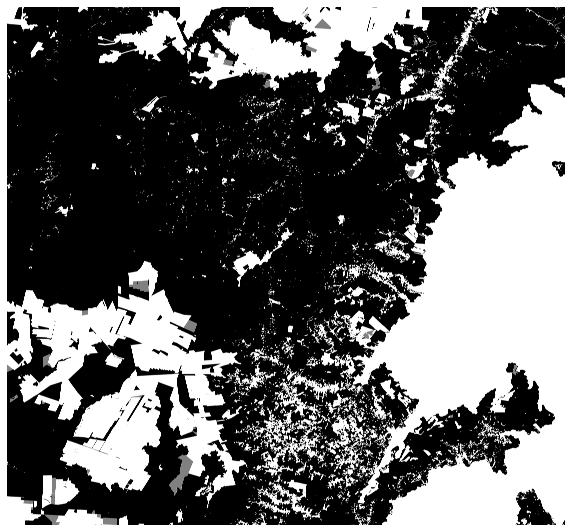

In [38]:

manager.logger.plotFigure(manager.label_mask, 
    name='label_mask', cmap=plt.cm.gray, savefig=False, figsize=(10,10))

In [39]:

manager.getImageChannels()

ic| base.py:149 in getImageChannels()
    self.image_stack.shape: (19355, 20840, 9)
ic| base.py:151 in getImageChannels()- self.channels: 9


In [40]:

manager.getTrainValTestMasks()

Training tiles:  [2, 4, 5, 6, 7, 12, 14, 15, 18, 21, 23, 25]
Validation tiles:  [9, 11, 24]
Test tiles:  [1, 3, 8, 10, 13, 16, 17, 19, 20, 22]


In [41]:
if config['use_entire_image_as_training'] == True:
    manager.mask_train_val[manager.mask_train_val == 0] = 1 # convert all test areas to train
    manager.mask_test[manager.mask_test == 1] = 0 # convert all test areas to train

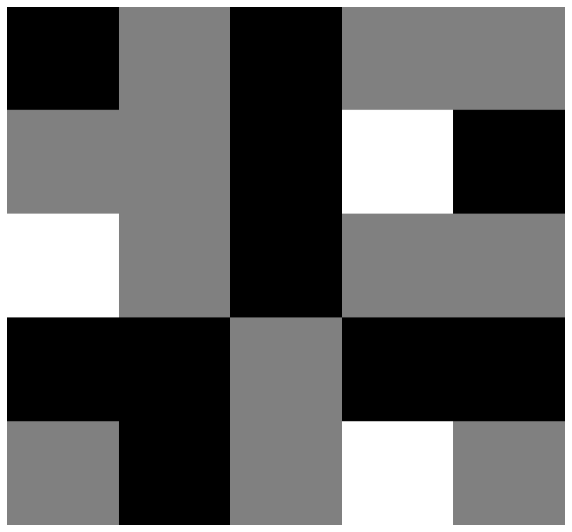

In [42]:
manager.logger.plotFigure(manager.mask_train_val, 
    name='image_stack_first_channel', cmap=plt.cm.gray, savefig=False, figsize=(10,10))


In [43]:

train_unique = get_pixel_count_set(manager.label_mask, manager.mask_train_val, 1)
val_unique = get_pixel_count_set(manager.label_mask, manager.mask_train_val, 2)
test_unique = get_pixel_count_set(manager.label_mask, manager.mask_train_val, 0)

total_unique = np.unique(manager.label_mask, return_counts=True)

In [44]:
print("train unique", train_unique)
print("val unique", val_unique)
print("test unique", test_unique)

print("total unique", total_unique)


train unique (array([0, 1, 2], dtype=uint8), array([128363214,   1113736,  64134986], dtype=int64))
val unique (array([0, 1, 2], dtype=uint8), array([36608647,   176538, 11617799], dtype=int64))
test unique (array([0, 1, 2], dtype=uint8), array([88315686,  1329210, 71698384], dtype=int64))
total unique (array([0, 1, 2], dtype=uint8), array([253287547,   2619484, 147451169], dtype=int64))


In [45]:
print("train unique percentage", np.round(train_unique[1]/np.sum(train_unique[1]), 4))
print("val unique", np.round(val_unique[1]/np.sum(val_unique[1]), 4))
print("test unique", np.round(test_unique[1]/np.sum(test_unique[1]), 4))

train unique percentage [0.663  0.0058 0.3313]
val unique [0.7563 0.0036 0.24  ]
test unique [0.5474 0.0082 0.4444]


In [46]:

if config["training"] == True:
    # Extracting patches from the idx matrix
    manager.createIdxImage()


In [47]:
if config["training"] == True:
    manager.extractCoords()

In [48]:
if config["training"] == True:
    manager.trainTestSplit()

In [49]:
if config["training"] == True:
    manager.label_mask.shape

In [50]:
if config["training"] == True:

    manager.logger.plotFigure(manager.label_mask[...,-1], 
        name='Reference', cmap=plt.cm.gray, savefig=False)



In [51]:
if config["training"] == True:
    np.unique(manager.label_mask)

In [52]:
if config["training"] == True:
    print(manager.coords_train)

In [53]:
if config["training"] == True:
    manager.retrieveSamplesOfInterest()

In [54]:
if config["training"] == True:
    inputSnipShow = True

In [55]:
# count, unique = np.unique(label_mask, return_counts=True)
# print(count, unique)
# print(unique[1]/unique[0])

In [56]:
'''
count, unique = np.unique(label_mask[mask_test == 1], return_counts=True)
print(count, unique)
print(unique[1]/unique[0])
'''

'\ncount, unique = np.unique(label_mask[mask_test == 1], return_counts=True)\nprint(count, unique)\nprint(unique[1]/unique[0])\n'

In [57]:
'''
count, unique = np.unique(label_mask[mask_train_val == 1], return_counts=True)
print(count, unique)
print(unique[1]/unique[0])
'''

'\ncount, unique = np.unique(label_mask[mask_train_val == 1], return_counts=True)\nprint(count, unique)\nprint(unique[1]/unique[0])\n'

In [58]:
manager.dataset.image_channels

[[0, 1, 2, 3, 4, 5, 6, 7, 8]]

In [59]:
manager.dataset.bands

4

In [60]:
manager.dataset.previewBandsSnip

[[1, 2, 3], [5, 6, 7]]

In [61]:
if config["training"] == True:
    if inputSnipShow == True:
        manager.snipDataset(idx = 1000)


In [62]:
if config["training"] == True:
    if inputSnipShow == True:
        manager.snipDataset(idx = 97)


In [63]:
if config["training"] == True:
    if inputSnipShow == True:

        manager.snipDataset(idx = 500)

In [64]:
if config["training"] == True:
    if inputSnipShow == True:

        manager.snipDataset(idx = 400)

In [65]:
if config["training"] == True:
    if inputSnipShow == True:

        manager.snipDataset(idx = 400)

In [66]:
if config["training"] == True:
    manager.getGenerators()


In [67]:
if config["training"] == True:
    manager.fixChannelNumber()

In [68]:
if config["training"] == True:
    print(manager.path_exp)

In [69]:
if config["training"] == True:
    print(manager.channels)

In [70]:
if config["training"] == True:
    print(manager.image_stack.shape)

In [71]:
if config["training"] == True:
    print("config['training_times']", config["training_times"])

In [72]:
manager.class_n

3

In [73]:
if config["training"] == True:
    for tm in range(config['training_times']):
        manager.repetition_id = tm
        manager.train()

In [74]:
if config["training"] == True:
    manager.plotHistory()


In [75]:
repetition_id = 0

In [76]:
if config["inferring"] != True:
    sys.exit()
else:
    manager.repetition_id = repetition_id

In [77]:
manager.image_stack.shape

(19355, 20840, 9)

In [78]:
manager.patchesHandler.dataset.image_channels[-1]

[0, 1, 2, 3, 4, 5, 6, 7, 8]

In [79]:
if issubclass(type(dataset), MultipleDates):
	manager.channels = manager.patchesHandler.input_image_shape
	manager.image_stack = manager.image_stack[..., manager.patchesHandler.dataset.image_channels[-1]]
	manager.label_mask = manager.label_mask[...,-1]


In [80]:
manager.image_stack.shape

(19355, 20840, 9)

In [81]:
manager.setPadding()

-5.0 -24.0


In [82]:
import src.network as network
from tensorflow.keras.models import Model, load_model, Sequential
'''
def infer(self):

    self.h, self.w, self.c = self.image1_pad.shape
    self.c = self.channels
    patch_size_rows = self.h//self.n_rows
    patch_size_cols = self.w//self.n_cols
    num_patches_x = int(self.h/patch_size_rows)
    num_patches_y = int(self.w/patch_size_cols)

    ic(self.path_models+ '/' + self.method +'_'+str(self.repetition_id)+'.h5')
    model = load_model(self.path_models+ '/' + self.method +'_'+str(self.repetition_id)+'.h5', compile=False)
    
    if self.classes_mode == False:
        class_n = 3
        self.patchesHandler.class_n = class_n
    else:
        class_n = 2    
        self.patchesHandler.class_n = class_n + 1
    if self.config["loadInference"] == False:
        if self.config["save_probabilities"] == False:
            if self.classes_mode == False:
                self.prob_rec = np.zeros((self.image1_pad.shape[0],self.image1_pad.shape[1], self.config["inference_times"]), dtype = np.float32)
            else:
                self.prob_rec = np.zeros((self.image1_pad.shape[0],self.image1_pad.shape[1], class_n, self.config["inference_times"]), dtype = np.float32)

            # self.prob_rec = np.zeros((image1_pad.shape[0],image1_pad.shape[1], class_n, self.config["inference_times"]), dtype = np.float32)
        print("Dropout training mode: {}".format(self.config['dropout_training']))
        new_model = network.build_resunet_dropout_spatial(input_shape=(patch_size_rows,patch_size_cols, self.c), 
            nb_filters = self.nb_filters, n_classes = class_n, dropout_seed = None, training=self.config['dropout_training'])

        for l in range(1, len(model.layers)):
            new_model.layers[l].set_weights(model.layers[l].get_weights())
        
        

        metrics_all =[]
        with tf.device('/cpu:0'):
            for tm in range(0,self.config["inference_times"]):

                print('time: ', tm)

                
                # Recinstructing predicted map
                start_test = time.time()
                
                prob_reconstructed = self.patchesHandler.infer(
                        new_model, self.image1_pad, self.h, self.w, 
                        num_patches_x, num_patches_y, patch_size_rows, 
                        patch_size_cols, classes_mode = self.classes_mode)
                        
                ts_time =  time.time() - start_test

                if self.config["save_probabilities"] == True:
                    np.save(self.path_maps+'/'+'prob_'+str(tm)+'.npy',prob_reconstructed) 
                else:
                    self.prob_rec[...,tm] = prob_reconstructed
                
                metrics_all.append(ts_time)
                del prob_reconstructed
            metrics_ = np.asarray(metrics_all)
            # Saving test time
            np.save(self.path_exp+'/metrics_ts.npy', metrics_)
    del self.image1_pad
'''

'\ndef infer(self):\n\n    self.h, self.w, self.c = self.image1_pad.shape\n    self.c = self.channels\n    patch_size_rows = self.h//self.n_rows\n    patch_size_cols = self.w//self.n_cols\n    num_patches_x = int(self.h/patch_size_rows)\n    num_patches_y = int(self.w/patch_size_cols)\n\n    ic(self.path_models+ \'/\' + self.method +\'_\'+str(self.repetition_id)+\'.h5\')\n    model = load_model(self.path_models+ \'/\' + self.method +\'_\'+str(self.repetition_id)+\'.h5\', compile=False)\n    \n    if self.classes_mode == False:\n        class_n = 3\n        self.patchesHandler.class_n = class_n\n    else:\n        class_n = 2    \n        self.patchesHandler.class_n = class_n + 1\n    if self.config["loadInference"] == False:\n        if self.config["save_probabilities"] == False:\n            if self.classes_mode == False:\n                self.prob_rec = np.zeros((self.image1_pad.shape[0],self.image1_pad.shape[1], self.config["inference_times"]), dtype = np.float32)\n            else:

In [83]:
'''
import types

manager.infer = types.MethodType(infer, manager)
'''


'\nimport types\n\nmanager.infer = types.MethodType(infer, manager)\n'

In [84]:
manager.infer()

time:  0
Loading model in: D:/Jorge/datasets/deforestation/experiments/PI/exp27/models/resunet_0.h5
runtime_repetition 135.46
time:  1
Loading model in: D:/Jorge/datasets/deforestation/experiments/PI/exp27/models/resunet_1.h5
runtime_repetition 138.84
time:  2
Loading model in: D:/Jorge/datasets/deforestation/experiments/PI/exp27/models/resunet_2.h5
runtime_repetition 138.25
time:  3
Loading model in: D:/Jorge/datasets/deforestation/experiments/PI/exp27/models/resunet_3.h5
runtime_repetition 140.63
time:  4
Loading model in: D:/Jorge/datasets/deforestation/experiments/PI/exp27/models/resunet_4.h5
runtime_repetition 140.32
time:  5
Loading model in: D:/Jorge/datasets/deforestation/experiments/PI/exp27/models/resunet_5.h5
runtime_repetition 140.37
time:  6
Loading model in: D:/Jorge/datasets/deforestation/experiments/PI/exp27/models/resunet_6.h5
runtime_repetition 138.52
time:  7
Loading model in: D:/Jorge/datasets/deforestation/experiments/PI/exp27/models/resunet_7.h5
runtime_repetition

In [85]:
manager.loadPredictedProbabilities()

In [86]:
manager.prob_rec.shape

(19360, 20864, 10)

In [87]:
'''
if useLessInferenceRuns == True:
    ic(reducedInferenceRuns)

    prob_rec_all = prob_rec.copy()
    prob_rec = prob_rec_all[:reducedInferenceRuns]
    prob_rec = np.transpose(np.squeeze(prob_rec), (1, 2, 0))
'''

'\nif useLessInferenceRuns == True:\n    ic(reducedInferenceRuns)\n\n    prob_rec_all = prob_rec.copy()\n    prob_rec = prob_rec_all[:reducedInferenceRuns]\n    prob_rec = np.transpose(np.squeeze(prob_rec), (1, 2, 0))\n'

In [88]:
manager.prob_rec.shape

(19360, 20864, 10)

In [89]:
manager.getMeanProb()

In [90]:
manager.logger.getStats(manager.mean_prob)

ic| Logger.py:121 in getStats()
    np.min(value): 4.9060762e-11
    np.mean(value): 0.01800514
    np.max(value): 0.9999999


In [91]:
ic(manager.mean_prob.shape)

ic| 3703776524.py:1 in <cell line: 1>()
    manager.mean_prob.shape: (19360, 20864)


(19360, 20864)

In [92]:
manager.unpadMeanProb()

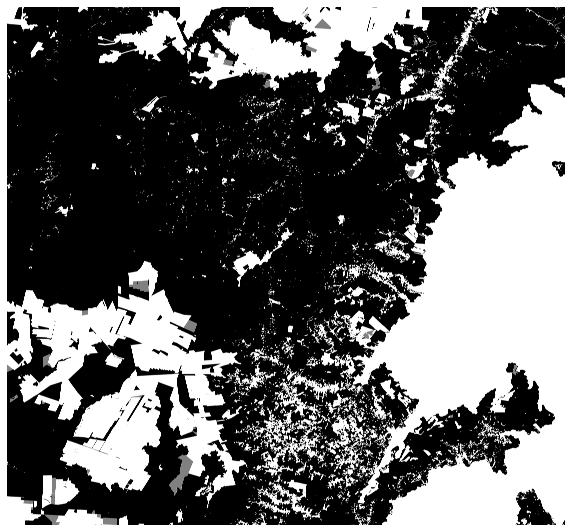

In [93]:
manager.logger.plotFigure(manager.label_mask, 
            name='Reference mask', figsize=(10,10), cmap=plt.cm.gray, savefig=True)

In [94]:
manager.squeezeLabel()

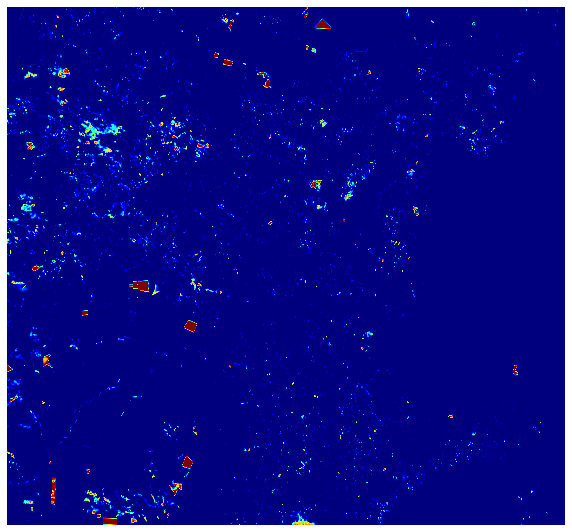

In [95]:
manager.setMeanProbNotConsideredAreas()
manager.logger.plotFigure(manager.mean_prob, 
            name='Mean predicted probability', figsize=(10,10), cmap='jet', savefig=False)

In [96]:
print(manager.label_mask.shape)

(19355, 20840)


In [97]:
# manager.getLabelTest()

In [98]:
# manager.getMAP()

In [99]:
manager.prob_rec.shape

(19360, 20864, 10)

In [100]:
manager.preprocessProbRec()
print(manager.prob_rec.shape)

(10, 19360, 20864, 1)


In [101]:
manager.prob_rec.shape

(10, 19360, 20864, 1)

In [102]:
manager.logger.getStats(manager.prob_rec)

ic| Logger.py:121 in getStats()
    np.min(value): 2.2739795e-26
    np.mean(value): 0.017999116
    np.max(value): 1.0


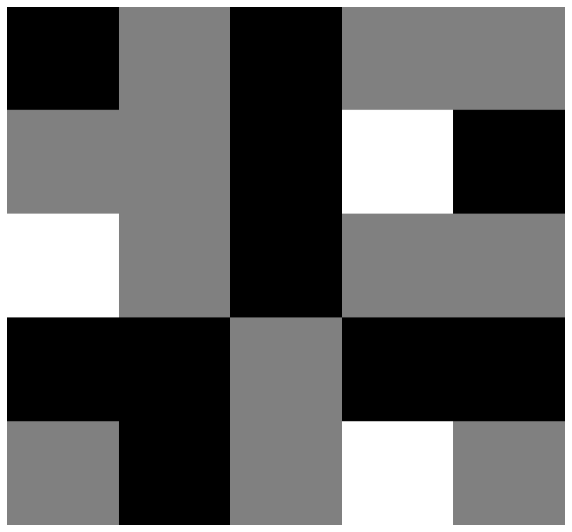

In [103]:
manager.logger.plotFigure(manager.mask_train_val, 
            name=manager.dataset.site + manager.title_name + ' Train val mask.png', figsize=(10,10), savefig=False)

In [104]:
manager.getLabelCurrentDeforestation()

In [105]:
manager.applyProbabilityThreshold()

(19355, 20840)
(array([0., 1.], dtype=float32), array([399617731,   3740469], dtype=int64))


ic| base.py:464 in applyProbabilityThreshold()
    self.predicted_unpad.shape: (19355, 20840)
    self.predicted.shape: (19355, 20840)


In [106]:
manager.getTestValues()

ic| base.py:487 in getTestValues()- predicted_test.shape: (161343280,)
ic| base.py:496 in getTestValues()- predicted_test.shape: (89644896,)


In [107]:
manager.removeSmallPolygons()

ic| metrics.py:213 in removeSmallPolygonsForMetrics()
    np.unique(predicted, return_counts=True): (array([0., 1.], dtype=float32), array([399617731,   3740469], dtype=int64))
    np.unique(predicted_larger_than_min_area, return_counts=True): (array([0., 1.], dtype=float32), array([399890797,   3467403], dtype=int64))
ic| metrics.py:215 in removeSmallPolygonsForMetrics()
    np.unique(ignored_polygons, return_counts=True): (array([0., 1.], dtype=float32), array([403085134,    273066], dtype=int64))


In [108]:
manager.calculateMetrics()

ic| base.py:540 in calculateMetrics()
    self.f1: 63.21
    self.precision: 61.05
    self.recall: 65.53


In [109]:
manager.getValidationValuesForMetrics()
manager.calculateMetricsValidation()

ic| base.py:469 in getValidationValuesForMetrics()
    self.label_mask_val.shape: (48402984,)
ic| base.py:475 in getValidationValuesForMetrics()
    self.label_mask_val_valid.shape: (36731724,)
ic| base.py:551 in calculateMetricsValidation()
    f1_val: 38.76
    precision_val: 28.36
    recall_val: 61.19
    mAP_val: 46.58


In [110]:
calculateMAPWithoutSmallPolygons = False
if calculateMAPWithoutSmallPolygons == True:
    manager.calculateMAPWithoutSmallPolygons()

In [111]:
manager.get_label_no_buffer()

D:/Jorge/datasets/deforestation/PI/deforestation_past_years.tif
Loaded deforestation past years


ic| dataset.py:706 in loadLabelFromDate()
    np.unique(deforestation_past_years, return_counts=True): (array([   0, 2002, 2004, 2006, 2008, 2010, 2012, 2013, 2014, 2015, 2016,
                                                                    2017, 2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([340580606,   4312043,   6953620,   5659916,   7162776,   6261432,
                                                                      8191420,   3233962,   3270293,   3044419,   1817289,   2359424,
                                                                      2201926,   3050229,   2901307,   2418575], dtype=int64))


Label where deforestation past years is actual date (2020) = 1


ic| dataset.py:709 in loadLabelFromDate()
    np.unique(deforestation_past_years, return_counts=True): (array([   0, 2002, 2004, 2006, 2008, 2010, 2012, 2013, 2014, 2015, 2016,
                                                                    2017, 2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([340580606,   4312043,   6953620,   5659916,   7162776,   6261432,
                                                                      8191420,   3233962,   3270293,   3044419,   1817289,   2359424,
                                                                      2201926,   3050229,   2901307,   2418575], dtype=int64))


Past deforestation different from 0 (no deforestation)


ic| dataset.py:713 in loadLabelFromDate()
    np.unique(deforestation_past_years, return_counts=True): (array([   0, 2002, 2004, 2006, 2008, 2010, 2012, 2013, 2014, 2015, 2016,
                                                                    2017, 2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([340580606,   4312043,   6953620,   5659916,   7162776,   6261432,
                                                                      8191420,   3233962,   3270293,   3044419,   1817289,   2359424,
                                                                      2201926,   3050229,   2901307,   2418575], dtype=int64))


Past deforestation before 2008 is 2
D:/Jorge/datasets/deforestation/PI/deforestation_before_2000_PI.tif


ic| dataset.py:717 in loadLabelFromDate()
    np.unique(label_past_deforestation_before_2008, return_counts=True): (array([  0, 208], dtype=uint8), array([385251297,  18167940], dtype=int64))
ic| dataset.py:719 in loadLabelFromDate()
    np.unique(deforestation_past_years, return_counts=True): (array([   0, 2002, 2004, 2006, 2008, 2010, 2012, 2013, 2014, 2015, 2016,
                                                                    2017, 2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([340580606,   4312043,   6953620,   5659916,   7162776,   6261432,
                                                                      8191420,   3233962,   3270293,   3044419,   1817289,   2359424,
                                                                      2201926,   3050229,   2901307,   2418575], dtype=int64))


D:/Jorge/datasets/sentinel2/PI/biome_limits.tif


ic| dataset.py:698 in loadLabel()
    label_per_date.shape: (19357, 20841, 1)


In [112]:
manager.getErrorMask()

(array([0., 1.], dtype=float32), array([400749439,   2608761], dtype=int64))


In [113]:
manager.getErrorMaskToShowRGB()

[0. 1.]


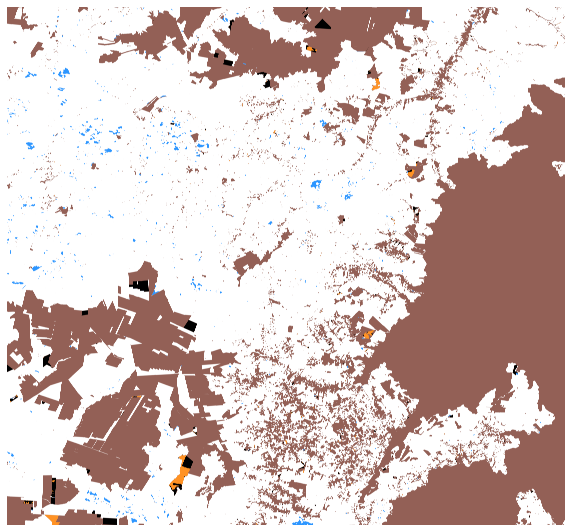

In [114]:
manager.logger.plotFigure(manager.error_mask_to_show_rgb[...,::-1], 
            name=manager.dataset.site + manager.title_name + ' error mask color.png', 
            figsize=(10,10), savefig=True, dpi=300)

In [115]:
'''
import types

manager.setUncertainty = types.MethodType(setUncertainty, manager)
'''


'\nimport types\n\nmanager.setUncertainty = types.MethodType(setUncertainty, manager)\n'

In [116]:
manager.config['uncertainty_method']

'pred_entropy'

In [117]:
manager.config['site']

'PI'

In [118]:
manager.config['uncertainty_method'] = "pred_entropy"


In [119]:
print(np.min(manager.prob_rec), np.mean(manager.prob_rec), np.max(manager.prob_rec))
print(np.std(manager.prob_rec))
print(manager.prob_rec.shape)

2.2739795e-26 0.017999116 1.0
0.11241221
(10, 19360, 20864, 1)


In [120]:
manager.setUncertainty()

pred_mean 4.9060762e-11 0.01800514 0.9999999
K = 1, pred_mean shape (19360, 20864, 1)


In [121]:
# manager.uncertainty_map[manager.uncertainty_map>1] = 1

In [122]:
manager.logger.getStats(manager.uncertainty_map)

ic| Logger.py:121 in getStats()
    np.min(value): 1.1646015e-09
    np.mean(value): 0.0164103
    np.max(value): 0.36787948


In [123]:
manager.getUncertaintyToShow()
manager.logger.getStats(manager.uncertainty_to_show)


ic| Logger.py:121 in getStats()
    np.min(value): 0.0
    np.mean(value): 0.011423735
    np.max(value): 0.36787948


ic| 3944692317.py:4 in <cell line: 4>()
    manager.uncertainty_to_show.shape: (19355, 20840)


(19355, 20840)

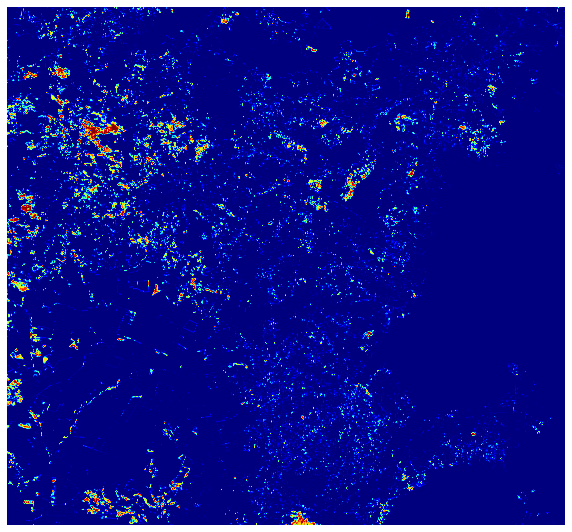

In [124]:

manager.logger.plotFigure(manager.uncertainty_to_show, 
            name=manager.dataset.site + manager.title_name + ' uncertainty '+manager.config['uncertainty_method']+'.png', figsize=(10,10), cmap='jet', savefig=True)

ic(manager.uncertainty_to_show.shape)



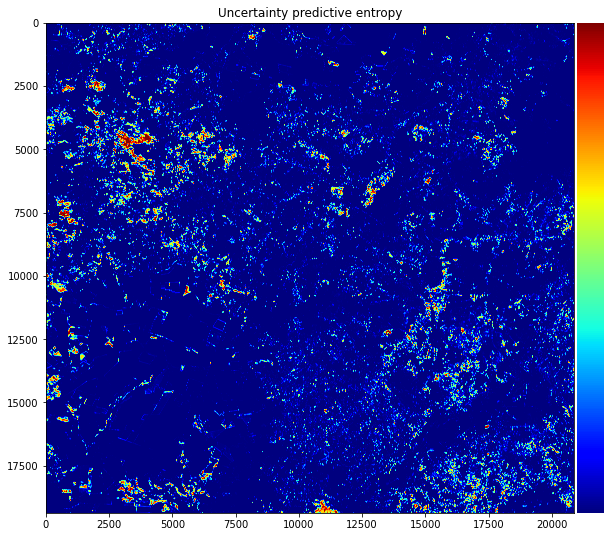

In [125]:

import src.uncertainty
fig, ax = plt.subplots(1,1,figsize=(10,10))
src.uncertainty.show_im(manager.uncertainty_map, ax, title = 'Uncertainty predictive entropy')
plt.axis('off')
plt.savefig('output/figures/Para' + manager.title_name + ' uncertainty '+manager.config['uncertainty_method']+'.png', 
    dpi=150, bbox_inches='tight')

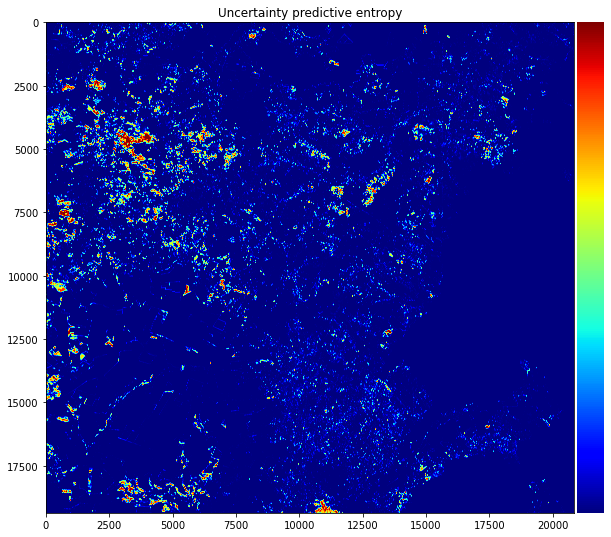

In [126]:

import src.uncertainty
fig, ax = plt.subplots(1,1,figsize=(10,10))
src.uncertainty.show_im(manager.uncertainty_to_show, ax, title = 'Uncertainty predictive entropy')
plt.axis('off')
plt.savefig('output/figures/Para' + manager.title_name + ' uncertainty '+manager.config['uncertainty_method']+'.png', 
    dpi=150, bbox_inches='tight')

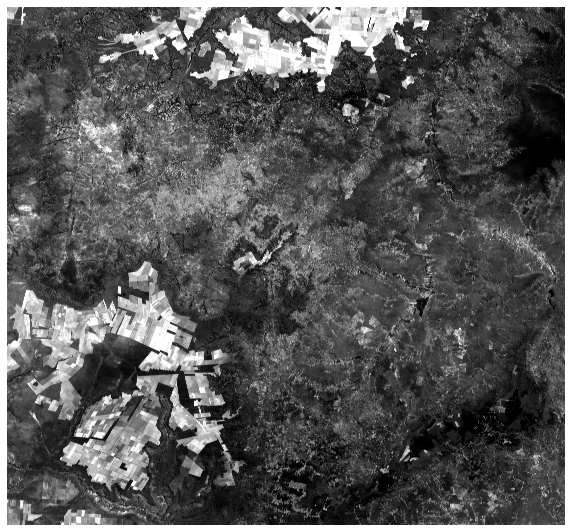

In [127]:

manager.logger.plotFigure(manager.image_stack[...,7], 
    name='image_stack_first_channel', cmap=plt.cm.gray, savefig=False, figsize=(10,10))

In [128]:
np.unique(manager.mask_train_val, return_counts=True)

(array([0, 1, 2], dtype=uint8),
 array([161343280, 193611936,  48402984], dtype=int64))

In [129]:
manager.error_mask.shape

(19355, 20840)

In [130]:
manager.npad

((0, 5), (0, 24), (0, 0))

In [131]:
manager.getValidationValues2()
manager.getTestValues2()

ic| base.py:591 in getTestValues2()
    self.label_mask.shape: (19355, 20840)
ic| base.py:592 in getTestValues2()
    self.mask_test.shape: (19355, 20840)
ic| base.py:596 in getTestValues2()
    self.label_mask_test.shape: (161343280,)
ic| base.py:604 in getTestValues2()
    self.error_mask_test.shape: (89559333,)


In [132]:
# manager.logger.plotCropSample(manager)

In [133]:
if config["plotLandsat"] == True:
    label_tmp_dates = []
    for date in dataset.prodes_dates:
        label_tmp_date = dataset.loadLabelFromDate(date)
        label_tmp_date = label_tmp_date[:manager.mask_tiles.shape[0], :manager.mask_tiles.shape[1]]
        label_tmp_dates.append(label_tmp_date)

In [134]:
if config["plotLandsat"] == True:
    # del manager.image_stack
    import src.lansdatLoader as ll
    import importlib
    importlib.reload(ll)
    landsatLoader = ll.LandsatLoader(dataset)
    ims = landsatLoader.load()
    for idx in range(len(ims)):
        ims[idx] = ims[idx][:manager.mask_tiles.shape[0], :manager.mask_tiles.shape[1],:]
    ims = landsatLoader.darken_past_deforestation(ims, manager.label_no_buffer)
    ims = landsatLoader.add_deforestation_edges_by_date(ims, label_tmp_dates[:])

In [135]:
if config["plotLandsat"] == True:
    logger.plotCropSampleLandsat(manager, ims)

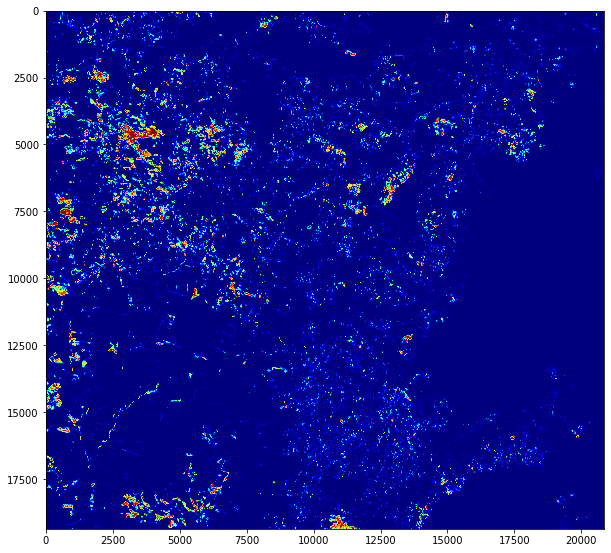

In [136]:
plt.figure(figsize=(10, 10))
plt.imshow(manager.uncertainty_to_show, cmap = 'jet')


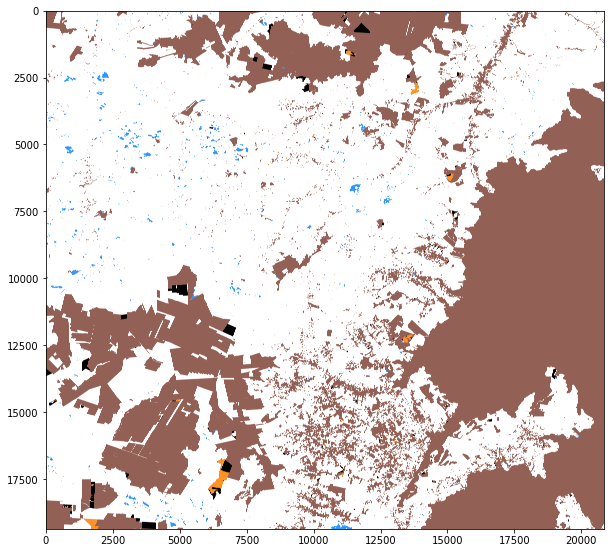

In [137]:
plt.figure(figsize=(10, 10))
plt.imshow(manager.error_mask_to_show_rgb[...,::-1])


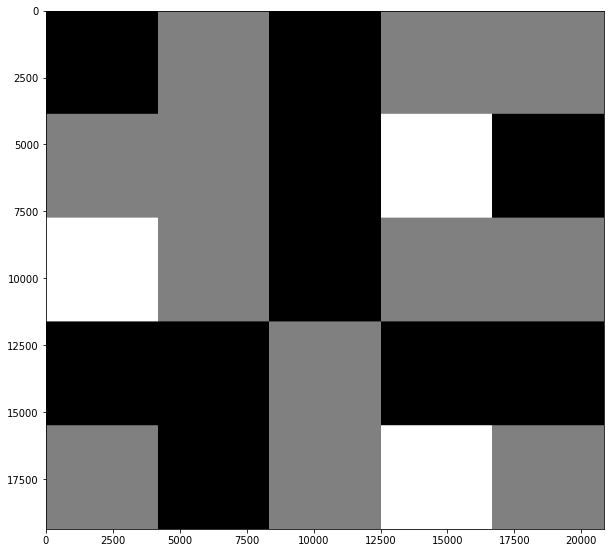

In [138]:
plt.figure(figsize=(10, 10))
plt.imshow(manager.mask_train_val, cmap='gray')

In [139]:
manager.mask_train_val.shape

(19355, 20840)

In [140]:
if config['site'] == 'PI':
    manager.dataset.previewLims1 = np.array([2000, 3000, 1500, 2500])
    # manager.dataset.previewLims2 = np.array([6300, 7300, 10000, 11000])
    manager.dataset.previewLims2 = np.array([2200, 3200, 9000, 10000])
elif config['site'] == 'MS':
    manager.dataset.previewLims1 = np.array([13250, 14250, 4000, 5000])
    # manager.dataset.previewLims2 = np.array([6300, 7300, 10000, 11000])
    manager.dataset.previewLims2 = np.array([13500, 14500, 16250, 17250])


In [173]:

if config['site'] == 'MS':
    previewLims0 = np.array([6000, 7000, 15600, 16600])
    manager.logger.plotCropSampleT0T1(manager, previewLims0, save_name='0')
    previewLims3 = np.array([2200, 3200, 16300, 17300])
    manager.logger.plotCropSampleT0T1(manager, previewLims3, save_name='3')
    previewLims4 = np.array([12500, 13500, 7000, 8000])    
    manager.logger.plotCropSampleT0T1(manager, previewLims4, save_name='4')

elif config['site'] == 'PI':

    manager.dataset.previewLims1 = np.array([18355, 19355, 10600, 11600])



In [222]:
import gc
gc.collect()

12445

In [174]:
if config['site'] == 'PI':

    manager.dataset.previewLims2 = np.array([100, 1100, 7700, 8700])


ic| Logger.py:279 in plotCropSampleT0T1()
    np.unique(manager.mask_test[lims[0]:lims[1], lims[2]:lims[3]]): array([0], dtype=uint8)
ic| Logger.py:281 in plotCropSampleT0T1()
    np.unique(manager.mask_test[lims[0]:lims[1], lims[2]:lims[3]], return_counts=True): (array([0, 1], dtype=uint8), array([636000, 364000], dtype=int64))


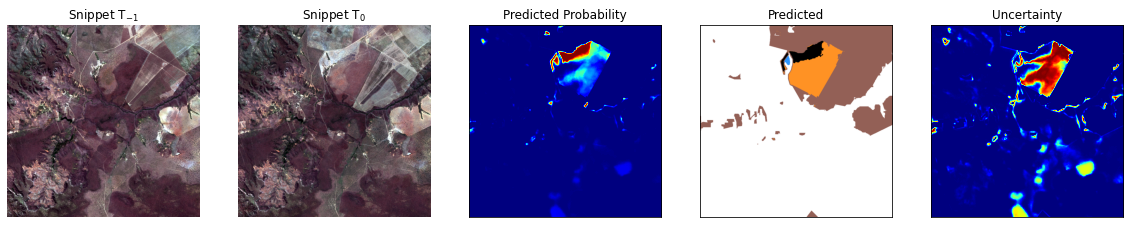

In [219]:
if config['site'] == 'PI':
    previewLims0 = np.array([6000, 7000, 14500, 15500])    

    manager.logger.plotCropSampleT0T1(manager, previewLims0, save_name='0')


ic| Logger.py:279 in plotCropSampleT0T1()
    np.unique(manager.mask_test[lims[0]:lims[1], lims[2]:lims[3]]): array([0], dtype=uint8)
ic| Logger.py:281 in plotCropSampleT0T1()
    np.unique(manager.mask_test[lims[0]:lims[1], lims[2]:lims[3]], return_counts=True): (array([0, 1], dtype=uint8), array([636000, 364000], dtype=int64))


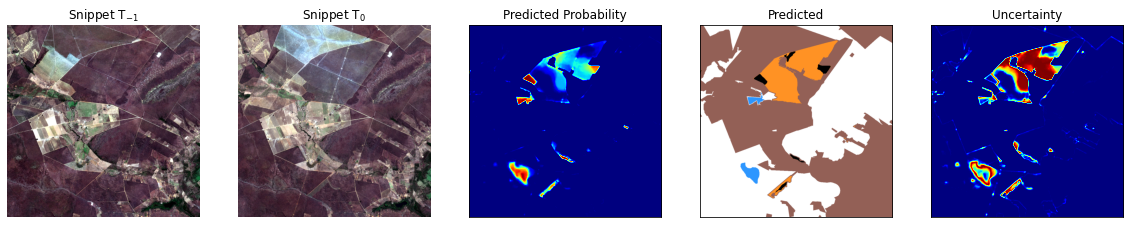

In [221]:
if config['site'] == 'PI':
    previewLims3 = np.array([12000, 13000, 13000, 14000])    

    manager.logger.plotCropSampleT0T1(manager, previewLims3, save_name='3')


ic| Logger.py:279 in plotCropSampleT0T1()
    np.unique(manager.mask_test[lims[0]:lims[1], lims[2]:lims[3]]): array([0], dtype=uint8)
ic| Logger.py:281 in plotCropSampleT0T1()
    np.unique(manager.mask_test[lims[0]:lims[1], lims[2]:lims[3]], return_counts=True): (array([0, 1], dtype=uint8), array([636000, 364000], dtype=int64))


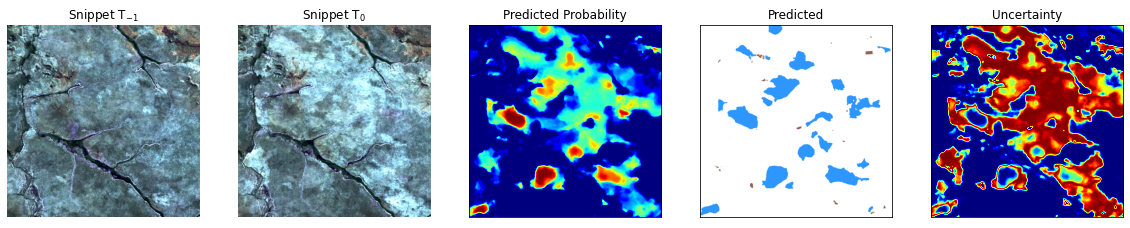

In [217]:
if config['site'] == 'PI':
    previewLims4 = np.array([4300, 5300, 2600, 3600])    

    manager.logger.plotCropSampleT0T1(manager, previewLims4, save_name='4')


ic| Logger.py:279 in plotCropSampleT0T1()
    np.unique(manager.mask_test[lims[0]:lims[1], lims[2]:lims[3]]): array([0], dtype=uint8)
ic| Logger.py:281 in plotCropSampleT0T1()
    np.unique(manager.mask_test[lims[0]:lims[1], lims[2]:lims[3]], return_counts=True): (array([0, 1], dtype=uint8), array([636000, 364000], dtype=int64))
ic| Logger.py:279 in plotCropSampleT0T1()
    np.unique(manager.mask_test[lims[0]:lims[1], lims[2]:lims[3]]): array([0], dtype=uint8)
ic| Logger.py:281 in plotCropSampleT0T1()
    np.unique(manager.mask_test[lims[0]:lims[1], lims[2]:lims[3]], return_counts=True): (array([0, 1], dtype=uint8), array([636000, 364000], dtype=int64))
ic| Logger.py:279 in plotCropSampleT0T1()
    np.unique(manager.mask_test[lims[0]:lims[1], lims[2]:lims[3]]): array([0], dtype=uint8)
ic| Logger.py:281 in plotCropSampleT0T1()
    np.unique(manager.mask_test[lims[0]:lims[1], lims[2]:lims[3]], return_counts=True): (array([0, 1], dtype=uint8), array([636000, 364000], dtype=int64))


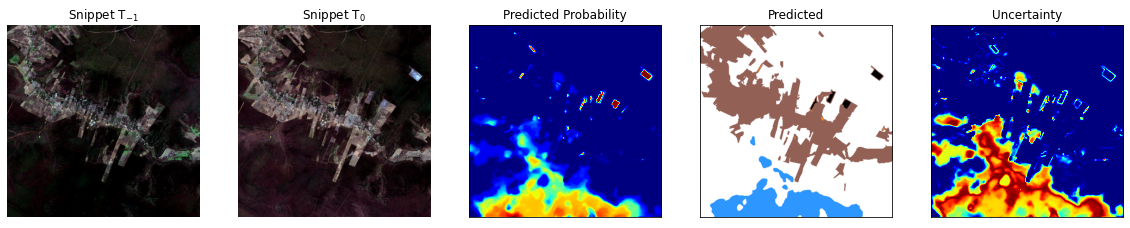

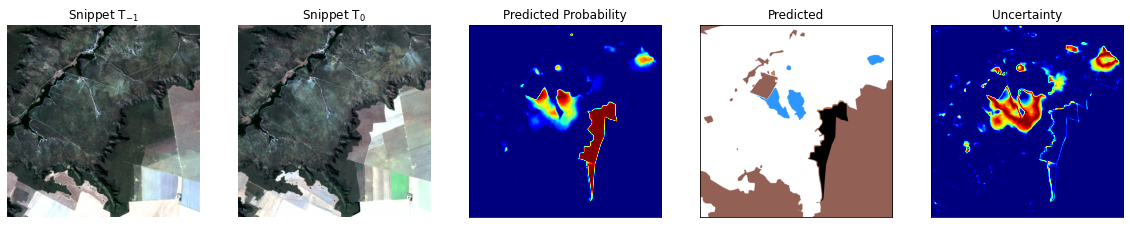

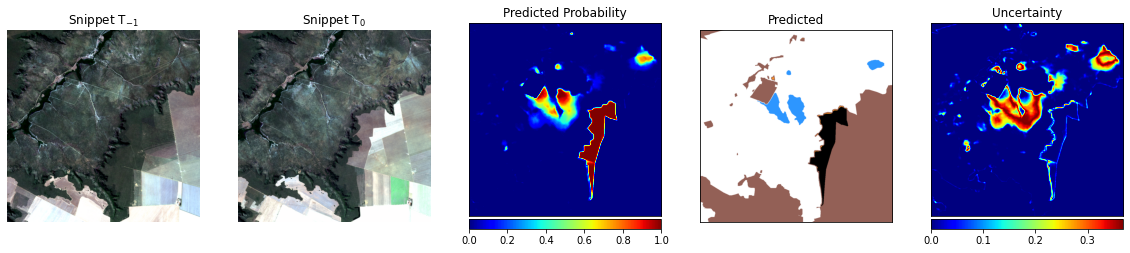

In [176]:
'''
manager.dataset.previewLims1 = np.array([2500, 5000, 15000, 17500])
manager.logger.plotCropSampleT0T1(manager, manager.dataset.previewLims1, save_name='0')
manager.dataset.previewLims1 = np.array([12500, 15000, 2500, 5000])
manager.logger.plotCropSampleT0T1(manager, manager.dataset.previewLims1, save_name='1')
manager.dataset.previewLims1 = np.array([15000, 17500, 2000, 3000])
manager.dataset.previewLims1 = np.array([5000, 7500, 15000, 17500])

manager.logger.plotCropSampleT0T1(manager, manager.dataset.previewLims1, save_name='2')
'''


manager.logger.plotCropSampleT0T1(manager, manager.dataset.previewLims1, save_name='1')
manager.logger.plotCropSampleT0T1(manager, manager.dataset.previewLims2, save_name='2')

manager.logger.plotCropSampleT0T1(manager, manager.dataset.previewLims2, colorbar=True, save_name='Colorbar')

In [178]:
manager.logger.getStats(manager.uncertainty)


ic| Logger.py:121 in getStats()
    np.min(value): 1.1646015e-09
    np.mean(value): 0.015850246
    np.max(value): 0.36787948


In [179]:
'''
manager.getOtherUncertaintyMetrics()
print(manager.sUEO)

print(manager.ece_score)  
'''

'\nmanager.getOtherUncertaintyMetrics()\nprint(manager.sUEO)\n\nprint(manager.ece_score)  \n'

In [180]:
if config["plotPOI"] == True and config['site'] == 'PA':

    print(manager.mean_prob.shape)
    font = {'family': "Times New Roman",
            'color':  'white',
            'weight': 'bold',
            'size': 24,
            }

    lims = dataset.previewLims1
    im = manager.uncertainty_map[lims[0]:lims[1], lims[2]:lims[3]]
    plt.figure(figsize=(10,10))
    plt.imshow(im, cmap='jet')

    letters = ['A', 'B', 'C', 'D', 'E', 'F']

    for poi_id in range(4):
            
            plt.text(manager.dataset.snippet_coords['snippet_id0'][poi_id][1], 
                    manager.dataset.snippet_coords['snippet_id0'][poi_id][0], 
                    letters[poi_id], fontdict=font)
    plt.axis('off')

    plt.savefig(os.path.join('output/pdf_plot_results', 
                            'pdf_plot_poi0.png'), 
    dpi=150, bbox_inches='tight')

    lims = dataset.previewLims2
    im = manager.uncertainty_map[lims[0]:lims[1], lims[2]:lims[3]]
    plt.figure(figsize=(10,10))
    plt.imshow(im, cmap='jet')

    letters = ['E', 'F']

    print(manager.dataset.snippet_coords['snippet_id1'])
    for poi_id in range(2):
            
            plt.text(manager.dataset.snippet_coords['snippet_id1'][poi_id][1], 
                    manager.dataset.snippet_coords['snippet_id1'][poi_id][0], 
                    letters[poi_id], fontdict=font)
    plt.axis('off')
            
    plt.savefig(os.path.join('output/pdf_plot_results', 
                            'pdf_plot_poi1.png'), 
    dpi=150, bbox_inches='tight')

In [181]:
if config["plotPOI"] == True and config['site'] == 'PA':
    manager.getPOIValues()


In [182]:

if config["plotPOI"] == True and config['site'] == 'PA':
    import pickle
    with open('output/log/log_ensemble_.pkl', 'wb') as f:
                pickle.dump(manager.snippet_poi_results, f)


In [183]:
from scipy import optimize  

manager.getOptimalUncertaintyThreshold(bounds=(np.min(manager.uncertainty) + 0.000015, np.max(manager.uncertainty) - 0.0015))

ic| base.py:842 in getOptimalUncertaintyThreshold()
    bounds: (1.5001164601526327e-05, 0.3663794801235199)


c:\Users\jchamorro\Anaconda3\envs\tf2\lib\site-packages\scipy\optimize\_minimize.py:783: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "


0.13995377985626262
threshold 0.13995377985626262


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_classified_incorrect.shape: (3981374,)
    predicted_test_classified_incorrect.shape: (3981374,)
ic| metrics.py:301 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 3981374
    len(label_mask_current_deforestation_test): 89559333
ic| metrics.py:303 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 3981374
    len(label_mask_current_deforestation_test): 89559333


[0.81025414 0.73255509 0.56467856 0.04445515 0.24067099 0.39530191
 0.12569649]
0.22644070143185874
threshold 0.22644070143185874


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_classified_incorrect.shape: (2588314,)
    predicted_test_classified_incorrect.shape: (2588314,)
ic| metrics.py:301 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 2588314
    len(label_mask_current_deforestation_test): 89559333
ic| metrics.py:303 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 2588314
    len(label_mask_current_deforestation_test): 89559333


[0.73847923 0.72406511 0.60171927 0.02890055 0.20714357 0.31691248
 0.13253416]
0.2798925585479237
threshold 0.2798925585479237


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_classified_incorrect.shape: (1700855,)
    predicted_test_classified_incorrect.shape: (1700855,)
ic| metrics.py:301 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 1700855
    len(label_mask_current_deforestation_test): 89559333
ic| metrics.py:303 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 1700855
    len(label_mask_current_deforestation_test): 89559333


[0.69398888 0.71656385 0.62990802 0.01899138 0.15308863 0.20970541
 0.12926281]
0.21499443731406384
threshold 0.21499443731406384


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_classified_incorrect.shape: (2796358,)
    predicted_test_classified_incorrect.shape: (2796358,)
ic| metrics.py:301 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 2796358
    len(label_mask_current_deforestation_test): 89559333
ic| metrics.py:303 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 2796358
    len(label_mask_current_deforestation_test): 89559333


[0.74780304 0.72625664 0.5974913  0.03122352 0.21061532 0.32587084
 0.13125561]
0.222510100635963
threshold 0.222510100635963


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_classified_incorrect.shape: (2666993,)
    predicted_test_classified_incorrect.shape: (2666993,)
ic| metrics.py:301 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 2666993
    len(label_mask_current_deforestation_test): 89559333
ic| metrics.py:303 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 2666993
    len(label_mask_current_deforestation_test): 89559333


[0.74165065 0.72494369 0.60026111 0.02977906 0.20839055 0.31982857
 0.1318593 ]
0.220891389001267
threshold 0.220891389001267


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_classified_incorrect.shape: (2696669,)
    predicted_test_classified_incorrect.shape: (2696669,)
ic| metrics.py:301 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 2696669
    len(label_mask_current_deforestation_test): 89559333
ic| metrics.py:303 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 2696669
    len(label_mask_current_deforestation_test): 89559333


[0.74298397 0.72524236 0.59964458 0.03011042 0.20891989 0.32118892
 0.13167869]
0.2204803533730143
threshold 0.2204803533730143


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_classified_incorrect.shape: (2703993,)
    predicted_test_classified_incorrect.shape: (2703993,)
ic| metrics.py:301 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 2703993
    len(label_mask_current_deforestation_test): 89559333
ic| metrics.py:303 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 2703993
    len(label_mask_current_deforestation_test): 89559333


[0.74332954 0.72532364 0.59950037 0.0301922  0.20901468 0.32148057
 0.13164335]
0.22144145260091785
threshold 0.22144145260091785


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_classified_incorrect.shape: (2686877,)
    predicted_test_classified_incorrect.shape: (2686877,)
ic| metrics.py:301 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 2686877
    len(label_mask_current_deforestation_test): 89559333
ic| metrics.py:303 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 2686877
    len(label_mask_current_deforestation_test): 89559333


[0.74255383 0.72514272 0.59985212 0.03000108 0.20872599 0.32073097
 0.13174135]
0.2218496398282943
threshold 0.2218496398282943


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_classified_incorrect.shape: (2679287,)
    predicted_test_classified_incorrect.shape: (2679287,)
ic| metrics.py:301 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 2679287
    len(label_mask_current_deforestation_test): 89559333
ic| metrics.py:303 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 2679287
    len(label_mask_current_deforestation_test): 89559333


[0.74219188 0.72507303 0.59999863 0.02991633 0.2086389  0.32040518
 0.13178436]
0.22140386596868727
threshold 0.22140386596868727


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_classified_incorrect.shape: (2687599,)
    predicted_test_classified_incorrect.shape: (2687599,)
ic| metrics.py:301 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 2687599
    len(label_mask_current_deforestation_test): 89559333
ic| metrics.py:303 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 2687599
    len(label_mask_current_deforestation_test): 89559333


[0.7425906  0.72514994 0.59983763 0.03000914 0.20873381 0.32076246
 0.13173891]
0.2215373565727607
threshold 0.2215373565727607


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_classified_incorrect.shape: (2685096,)
    predicted_test_classified_incorrect.shape: (2685096,)
ic| metrics.py:301 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 2685096
    len(label_mask_current_deforestation_test): 89559333
ic| metrics.py:303 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 2685096
    len(label_mask_current_deforestation_test): 89559333


[0.74246733 0.7251288  0.59988875 0.0299812  0.2087008  0.32064219
 0.1317512 ]
0.2214747892187587
threshold 0.2214747892187587


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_classified_incorrect.shape: (2686294,)
    predicted_test_classified_incorrect.shape: (2686294,)
ic| metrics.py:301 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 2686294
    len(label_mask_current_deforestation_test): 89559333
ic| metrics.py:303 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 2686294
    len(label_mask_current_deforestation_test): 89559333
ic| base.py:846 in getOptimalUncertaintyThreshold()
    self.threshold_optimal: 0.22144145260091785


[0.74252449 0.72513372 0.59986128 0.02999457 0.2087263  0.32072047
 0.1317427 ]


In [184]:
manager.getUncertaintyMetricsFromOptimalThreshold()

threshold:  0.22144145260091785
threshold 0.22144145260091785


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_classified_incorrect.shape: (2686877,)
    predicted_test_classified_incorrect.shape: (2686877,)
ic| metrics.py:301 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 2686877
    len(label_mask_current_deforestation_test): 89559333
ic| metrics.py:303 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 2686877
    len(label_mask_current_deforestation_test): 89559333


[0.74255383 0.72514272 0.59985212 0.03000108 0.20872599 0.32073097
 0.13174135]
threshold 0.22144145260091785
(89559333,) (89559333,)


ic| base.py:877 in getUncertaintyMetricsFromOptimalThreshold()
    self.m_optimal: {'AA': array([0.03000108]),
                     'UEO': array([0.13174135]),
                     'f1': 63.21,
                     'f1_H': array([0.25288133]),
                     'f1_L': array([0.733745]),
                     'precision_H': array([0.20872599]),
                     'precision_L': array([0.74255383]),
                     'recall_H': array([0.32073097]),
                     'recall_L': array([0.72514272]),
                     'recall_Ltotal': array([0.59985212])}
ic| base.py:878 in getUncertaintyMetricsFromOptimalThreshold()
    self.m_audited_optimal: {'f1': array([0.78019922]),
                             'precision': array([0.78791538]),
                             'recall': array([0.77263273])}


cm_audited [[87976217   272558]
 [  297978  1012580]]
[0.78791538 0.77263273]


{'metrics': {'precision_L': array([0.74255383]),
  'recall_L': array([0.72514272]),
  'recall_Ltotal': array([0.59985212]),
  'AA': array([0.03000108]),
  'precision_H': array([0.20872599]),
  'recall_H': array([0.32073097]),
  'UEO': array([0.13174135]),
  'f1_L': array([0.733745]),
  'f1_H': array([0.25288133]),
  'f1': 63.21},
 'metrics_audited': {'precision': array([0.78791538]),
  'recall': array([0.77263273]),
  'f1': array([0.78019922])},
 'exp': 27}

In [185]:
from src import metrics as _metrics

def getUncertaintyAAValues(self):



    # self.threshold_list = [0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.25, 0.27, 0.3, 0.34, 0.36]

    # self.threshold_list = [0.005, 0.0075, 0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.25, 0.27, 0.3, 0.34, 0.36, np.max(uncertainty)-0.003]
    if self.config['uncertainty_method'] == "pred_entropy_single":
        self.threshold_list = [0.0075, 0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.225, 
                            0.25, 0.27, 0.3, 0.34, 0.36, np.max(self.uncertainty)-0.003, np.max(self.uncertainty)-0.0015]
    if self.config['uncertainty_method'] == "pred_entropy":
            if self.classes_mode == False:
                # self.threshold_list = [0.0025, 0.005, 0.0075, 0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.225, 
                #            0.25, 0.27, 0.3, 0.34, 0.36, np.max(self.uncertainty)-0.003, np.max(self.uncertainty)-0.0015]
                self.threshold_list = [0.005, 0.0075, 0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.225, 
                        0.25, 0.27, 0.3, 0.34, 0.36, np.max(self.uncertainty)-0.003, np.max(self.uncertainty)-0.0015]                            
                    # self.threshold_list = [0.0025, 0.025, 0.05, 0.1, 0.2, 0.4, 
                    #         0.5, 0.6, 0.7, 0.8, 0.9, np.max(self.uncertainty)-0.003, np.max(self.uncertainty)-0.0015]
            else:
                    self.threshold_list = [0.0025, 0.025, 0.05, 0.075, 0.1, 0.2, 0.4, 
                    0.5, 0.6, 0.7, 0.8, 0.9, np.max(self.uncertainty)-0.003, np.max(self.uncertainty)-0.0015]
                    
                    # self.threshold_list = [0.13, 0.15, 0.2, 0.225, 
                    # 0.25, 0.27, 0.3, 0.34, 0.36, 0.45, 0.55, 0.65, 0.8]
    elif self.config['uncertainty_method'] == "pred_var":
            self.threshold_list = [0.0025, 0.005, 0.0075, 0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.225, 
                    0.25, 0.27, 0.3, 0.34, 0.36]
            self.threshold_list = [x*0.13/0.36 for x in self.threshold_list] + [np.max(self.uncertainty)-0.0015, np.max(self.uncertainty)-0.0008]
            self.threshold_list = np.linspace(np.min(self.uncertainty) + 0.000015, np.max(self.uncertainty) - 0.0015, 19)
            self.threshold_list = [8e-05, 1.5e-04, 1.5e-03] + \
                list(np.linspace(np.min(self.uncertainty) + 0.000015, np.max(self.uncertainty) - 0.0015, 19))
            self.threshold_list.insert(0, self.threshold_list.pop(3))

            # self.threshold_list = np.linspace(np.min(self.uncertainty) + 0.00000015, np.max(self.uncertainty) - 0.0015, 19)
            # self.threshold_list = np.logspace(np.min(self.uncertainty) + 0.00000015, np.max(self.uncertainty) - 0.0015, 19)

    elif self.config['uncertainty_method'] == "MI":
            self.threshold_list = [0.0025, 0.005, 0.0075, 0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.225, 
                    0.25, 0.27, 0.3, 0.34, 0.36]
            self.threshold_list = [x*0.235/0.36 for x in self.threshold_list] + [np.max(self.uncertainty)-0.003, np.max(self.uncertainty)-0.0015]
            self.threshold_list = [0.00001, 0.0005, 0.0001] + [x*0.235/0.36 for x in self.threshold_list] + [np.max(self.uncertainty)-0.003, np.max(self.uncertainty)-0.0015]
    elif self.config['uncertainty_method'] == "KL":
            self.threshold_list = [0.0025, 0.005, 0.0075, 0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.225, 
                    0.25, 0.27, 0.3, 0.34, 0.36]
            self.threshold_list = [x*1.0/0.36 for x in self.threshold_list] + [np.max(self.uncertainty)-0.006, np.max(self.uncertainty)-0.003]
    elif self.config['uncertainty_method'] == "evidential":
            # self.threshold_list = [0.015, 0.03, 0.04]
            self.threshold_list = [0.0025, 0.005, 0.0075, 0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.225, 
                    0.25, 0.27, 0.3, 0.34, 0.36]
            self.threshold_list = [ 0.15, 0.2, 0.225, 
                    0.25, 0.27, 0.3, 0.34, 0.36]
            self.threshold_list = [ 0.15, 0.2, 0.225, 
                    0.25, 0.27, 0.3, 0.34, 0.36, 0.45, 0.55, 0.65, 0.8]

            self.threshold_list = [0.13, 0.15, 0.2, 0.225, 
                    0.25, 0.27, 0.3, 0.34, 0.36, 0.45, 0.55, 0.65, 0.8]

            # self.threshold_list = [ 0.15, 0.2,  
            #          0.3, 0.35, 0.4, 0.5, 0.6, 0.7]

            # self.threshold_list = [0.015,0.1, 0.2, 0.27, 0.36, 0.45, 0.55, 0.65]

            # self.threshold_list = [x*1.0/0.36 for x in self.threshold_list] + [np.max(uncertainty)-0.006, np.max(uncertainty)-0.003]
                    
            # self.threshold_list = np.linspace(np.min(uncertainty) + 0.0015, np.max(uncertainty) - 0.0015, 19)
    print(self.threshold_list)
    self.loadThresholdMetrics = False
    if self.loadThresholdMetrics == False:
            # self.threshold_list = [0.1]
            # y_test
            ic(self.uncertainty.shape, self.label_mask_current_deforestation_test.shape)

            metrics_values = _metrics.getAA_Recall(self.uncertainty, 
                    self.label_mask_current_deforestation_test, 
                    self.predicted_test, self.threshold_list)

            # ic(metrics_values)


    self.m = {'precision_L': metrics_values[:,0],
            'recall_L': metrics_values[:,1],
            'recall_Ltotal': metrics_values[:,2],
            'AA': metrics_values[:,3],
            'precision_H': metrics_values[:,4],
            'recall_H': metrics_values[:,5],
            'UEO': metrics_values[:,6]}

    self.m['f1_L'] = 2*self.m['precision_L']*self.m['recall_L']/(self.m['precision_L']+self.m['recall_L'])
    self.m['f1_H'] = 2*self.m['precision_H']*self.m['recall_H']/(self.m['precision_H']+self.m['recall_H'])


In [186]:
manager.config['uncertainty_method']

'pred_entropy'

In [187]:
# manager.threshold_list

In [188]:


# manager.threshold_list.insert(0, manager.threshold_list.pop(3))

In [189]:

import types

manager.getUncertaintyAAValues = types.MethodType(getUncertaintyAAValues, manager)



Get precision-recall threshold

In [190]:

manager.getUncertaintyAAValues()

ic| 642846373.py:73 in getUncertaintyAAValues()
    self.uncertainty.shape: (89559333,)
    self.label_mask_current_deforestation_test.shape: (89559333,)


[0.005, 0.0075, 0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.225, 0.25, 0.27, 0.3, 0.34, 0.36, 0.3648794801235199, 0.3663794801235199]
threshold 0.005


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_classified_incorrect.shape: (13696371,)
    predicted_test_classified_incorrect.shape: (13696371,)
ic| metrics.py:301 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 13696371
    len(label_mask_current_deforestation_test): 89559333
ic| metrics.py:303 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 13696371
    len(label_mask_current_deforestation_test): 89559333


[0.94825155 0.73879905 0.42439633 0.15293069 0.36894448 0.54251416
 0.05549499]
threshold 0.0075


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_classified_incorrect.shape: (12216255,)
    predicted_test_classified_incorrect.shape: (12216255,)
ic| metrics.py:301 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 12216255
    len(label_mask_current_deforestation_test): 89559333
ic| metrics.py:303 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 12216255
    len(label_mask_current_deforestation_test): 89559333


[0.94183061 0.7414285  0.44300443 0.13640404 0.3520394  0.52736503
 0.06112903]
threshold 0.01


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_classified_incorrect.shape: (11233805,)
    predicted_test_classified_incorrect.shape: (11233805,)
ic| metrics.py:301 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 11233805
    len(label_mask_current_deforestation_test): 89559333
ic| metrics.py:303 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 11233805
    len(label_mask_current_deforestation_test): 89559333


[0.9357578  0.74238774 0.45471318 0.12543422 0.34143449 0.51756262
 0.06549402]
threshold 0.015


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_classified_incorrect.shape: (9919635,)
    predicted_test_classified_incorrect.shape: (9919635,)
ic| metrics.py:301 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 9919635
    len(label_mask_current_deforestation_test): 89559333
ic| metrics.py:303 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 9919635
    len(label_mask_current_deforestation_test): 89559333


[0.92659247 0.74296894 0.4697068  0.11076048 0.32761464 0.50452056
 0.07247988]
threshold 0.025


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_classified_incorrect.shape: (8381267,)
    predicted_test_classified_incorrect.shape: (8381267,)
ic| metrics.py:301 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 8381267
    len(label_mask_current_deforestation_test): 89559333
ic| metrics.py:303 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 8381267
    len(label_mask_current_deforestation_test): 89559333


[0.91386652 0.74208376 0.48782274 0.0935834  0.31036063 0.48870474
 0.08278369]
threshold 0.05


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_classified_incorrect.shape: (6491302,)
    predicted_test_classified_incorrect.shape: (6491302,)
ic| metrics.py:301 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 6491302
    len(label_mask_current_deforestation_test): 89559333
ic| metrics.py:303 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 6491302
    len(label_mask_current_deforestation_test): 89559333


[0.88713314 0.73973958 0.51306924 0.07248046 0.28728536 0.46406694
 0.09944388]
threshold 0.08


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_classified_incorrect.shape: (5319554,)
    predicted_test_classified_incorrect.shape: (5319554,)
ic| metrics.py:301 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 5319554
    len(label_mask_current_deforestation_test): 89559333
ic| metrics.py:303 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 5319554
    len(label_mask_current_deforestation_test): 89559333


[0.85886624 0.73606391 0.53248006 0.05939698 0.27085241 0.44394449
 0.1116669 ]
threshold 0.1


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_classified_incorrect.shape: (4778500,)
    predicted_test_classified_incorrect.shape: (4778500,)
ic| metrics.py:301 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 4778500
    len(label_mask_current_deforestation_test): 89559333
ic| metrics.py:303 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 4778500
    len(label_mask_current_deforestation_test): 89559333


[0.84173374 0.73482258 0.54519067 0.05335569 0.25862854 0.42654986
 0.11748589]
threshold 0.15


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_classified_incorrect.shape: (3812844,)
    predicted_test_classified_incorrect.shape: (3812844,)
ic| metrics.py:301 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 3812844
    len(label_mask_current_deforestation_test): 89559333
ic| metrics.py:303 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 3812844
    len(label_mask_current_deforestation_test): 89559333


[0.80234309 0.73179355 0.56871272 0.04257339 0.23746036 0.38840097
 0.12715218]
threshold 0.2


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_classified_incorrect.shape: (3029900,)
    predicted_test_classified_incorrect.shape: (3029900,)
ic| metrics.py:301 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 3029900
    len(label_mask_current_deforestation_test): 89559333
ic| metrics.py:303 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 3029900
    len(label_mask_current_deforestation_test): 89559333


[0.76072791 0.72835605 0.59201806 0.0338312  0.21433891 0.33790019
 0.13085335]
threshold 0.225


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_classified_incorrect.shape: (2618530,)
    predicted_test_classified_incorrect.shape: (2618530,)
ic| metrics.py:301 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 2618530
    len(label_mask_current_deforestation_test): 89559333
ic| metrics.py:303 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 2618530
    len(label_mask_current_deforestation_test): 89559333


[0.73966963 0.72440736 0.60118285 0.02923794 0.20758325 0.31795488
 0.13225488]
threshold 0.25


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_classified_incorrect.shape: (2089096,)
    predicted_test_classified_incorrect.shape: (2089096,)
ic| metrics.py:301 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 2089096
    len(label_mask_current_deforestation_test): 89559333
ic| metrics.py:303 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 2089096
    len(label_mask_current_deforestation_test): 89559333


[0.72126492 0.72079582 0.6181718  0.02332639 0.17154118 0.26055244
 0.13725015]
threshold 0.27


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_classified_incorrect.shape: (1823660,)
    predicted_test_classified_incorrect.shape: (1823660,)
ic| metrics.py:301 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 1823660
    len(label_mask_current_deforestation_test): 89559333
ic| metrics.py:303 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 1823660
    len(label_mask_current_deforestation_test): 89559333


[0.7038931  0.71818768 0.62693448 0.02036259 0.15512351 0.22299423
 0.13309422]
threshold 0.3


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_classified_incorrect.shape: (1445569,)
    predicted_test_classified_incorrect.shape: (1445569,)
ic| metrics.py:301 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 1445569
    len(label_mask_current_deforestation_test): 89559333
ic| metrics.py:303 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 1445569
    len(label_mask_current_deforestation_test): 89559333


[0.67221476 0.71337717 0.63627325 0.01614091 0.14981765 0.17574427
 0.11796858]
threshold 0.34


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_classified_incorrect.shape: (871154,)
    predicted_test_classified_incorrect.shape: (871154,)
ic| metrics.py:301 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 871154
    len(label_mask_current_deforestation_test): 89559333
ic| metrics.py:303 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 871154
    len(label_mask_current_deforestation_test): 89559333


[0.62084154 0.70499768 0.65145305 0.00972712 0.15887643 0.05023258
 0.06915462]
threshold 0.36


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_classified_incorrect.shape: (462180,)
    predicted_test_classified_incorrect.shape: (462180,)
d:\Jorge\deforestation_uncertainty\src\metrics.py:297: RuntimeWarning: invalid value encountered in longlong_scalars
  precision_H = TP_H / (TP_H + FP_H)
ic| metrics.py:301 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 462180
    len(label_mask_current_deforestation_test): 89559333
ic| metrics.py:303 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 462180
    len(label_mask_current_deforestation_test): 89559333


[0.61050597 0.68590627 0.65526821 0.0051606         nan 0.
 0.0417156 ]
threshold 0.3648794801235199


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_classified_incorrect.shape: (279915,)
    predicted_test_classified_incorrect.shape: (279915,)
d:\Jorge\deforestation_uncertainty\src\metrics.py:297: RuntimeWarning: invalid value encountered in longlong_scalars
  precision_H = TP_H / (TP_H + FP_H)
ic| metrics.py:301 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 279915
    len(label_mask_current_deforestation_test): 89559333
ic| metrics.py:303 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 279915
    len(label_mask_current_deforestation_test): 89559333


[0.61050597 0.67375518 0.65526821 0.00312547        nan 0.
 0.02891542]
threshold 0.3663794801235199


ic| metrics.py:267 in getAA_Recall()
    label_current_deforestation_test_classified_incorrect.shape: (197228,)
    predicted_test_classified_incorrect.shape: (197228,)
d:\Jorge\deforestation_uncertainty\src\metrics.py:297: RuntimeWarning: invalid value encountered in longlong_scalars
  precision_H = TP_H / (TP_H + FP_H)
ic| metrics.py:301 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 197228
    len(label_mask_current_deforestation_test): 89559333
ic| metrics.py:303 in getAA_Recall()
    TP_H + FN_H + FP_H + TN_H: 197228
    len(label_mask_current_deforestation_test): 89559333


[0.61050597 0.66813998 0.65526821 0.0022022         nan 0.
 0.02154906]


In [191]:
manager.getUncertaintyAAAuditedValues()

ic| base.py:733 in getUncertaintyAAAuditedValues()
    self.uncertainty.shape: (89559333,)
    self.label_mask_current_deforestation_test.shape: (89559333,)


threshold 0.005
(89559333,) (89559333,)
cm_audited [[88218422    30353]
 [  196642  1113916]]
[0.97347389 0.84995552]
threshold 0.0075
(89559333,) (89559333,)
cm_audited [[88212917    35858]
 [  202477  1108081]]
[0.96865392 0.84550321]
threshold 0.01
(89559333,) (89559333,)
cm_audited [[88207863    40912]
 [  206790  1103768]]
[0.96425901 0.84221225]
threshold 0.015
(89559333,) (89559333,)
cm_audited [[88200007    48768]
 [  212960  1097598]]
[0.95745861 0.83750433]
threshold 0.025
(89559333,) (89559333,)
cm_audited [[88188518    60257]
 [  222200  1088358]]
[0.94753943 0.8304539 ]
threshold 0.05
(89559333,) (89559333,)
cm_audited [[88163227    85548]
 [  236571  1073987]]
[0.92622215 0.81948834]
threshold 0.08
(89559333,) (89559333,)
cm_audited [[88134101   114674]
 [  250232  1060326]]
[0.90240511 0.80906454]
threshold 0.1
(89559333,) (89559333,)
cm_audited [[88114431   134344]
 [  257845  1052713]]
[0.88682599 0.80325556]
threshold 0.15
(89559333,) (89559333,)
cm_audited [[88065163

ic| base.py:739 in getUncertaintyAAAuditedValues()
    metric_values_audited: array([[0.97347389, 0.84995552],
                                  [0.96865392, 0.84550321],
                                  [0.96425901, 0.84221225],
                                  [0.95745861, 0.83750433],
                                  [0.94753943, 0.8304539 ],
                                  [0.92622215, 0.81948834],
                                  [0.90240511, 0.80906454],
                                  [0.88682599, 0.80325556],
                                  [0.84962187, 0.79156359],
                                  [0.80712093, 0.77920397],
                                  [0.78472436, 0.77128673],
                                  [0.76097225, 0.7605478 ],
                                  [0.7408612 , 0.75399486],
                                  [0.70580804, 0.74435622],
                                  [0.64643314, 0.72740314],
                                  [0.62606778, 0.

cm_audited [[87700894   547881]
 [  426543   884015]]
[0.61737375 0.67453329]


In [192]:
manager.setPlotLimsForUncertaintyAA()

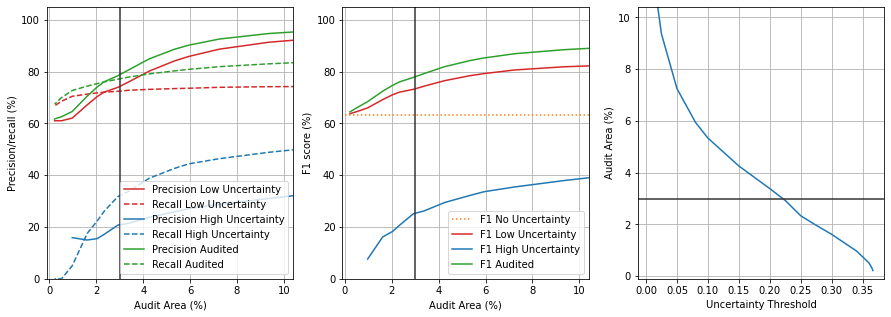

In [193]:
'''
xlim = [-0.3, 12.7]
xlim = [-0.1, 10.4]

ylim = [0, 105]
'''
manager.plotUncertaintyAA(normalize_xlim=False)

In [194]:
manager.dataset.paths.im_filenames[dates[1]][0]
manager.dataset.paths.optical_im_past_dates[dates[1]]

'D:/Jorge/datasets/sentinel2/PI/2020'

In [195]:
config['georreferenced_save'] = True

In [196]:
if config['georreferenced_save'] == True:
    produced_im_path = 'D:/Jorge/deforestation_uncertainty/georreferenced/{}_uncertainty_georreferenced.tif'.format(
        manager.dataset.site)
    print("manager.uncertainty_to_show.shape", manager.uncertainty_to_show.shape)
    save_georreferenced(manager.uncertainty_to_show, original_im_path,produced_im_path)


manager.uncertainty_to_show.shape (19355, 20840)
im_pad.shape (19355, 20841)
im_pad.shape (1, 19355, 20841)


In [197]:
manager.predicted_unpad.shape

(19355, 20840)

In [207]:

if config['georreferenced_save'] == True:
    produced_im_path = 'D:/Jorge/deforestation_uncertainty/georreferenced/{}_uncertainty_georreferenced_jet.tif'.format(
        manager.dataset.site)

    jet_colormap_image = plt.get_cmap('jet')(manager.uncertainty_to_show)[..., :-1]
    jet_colormap_image = (jet_colormap_image * 255).astype('uint8')
    save_georreferenced(jet_colormap_image, original_im_path,produced_im_path, bands = 3)


im_pad.shape (19355, 20841, 3)
im_pad.shape (3, 19355, 20841)


In [ ]:
del jet_colormap_image

In [212]:
# jet_colormap_image.shape
jet_colormap_image = plt.get_cmap('jet')(manager.uncertainty_to_show)
jet_colormap_image = (jet_colormap_image * 255).astype('uint8')

In [210]:
print(np.min(jet_colormap_image), np.max(jet_colormap_image))

0.0 1.0


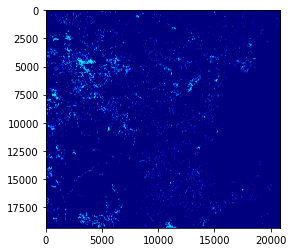

In [213]:
plt.imshow(jet_colormap_image[...,:-1])

In [201]:
if config['georreferenced_save'] == True:
    predicted_to_show = manager.predicted_unpad.copy()
    predicted_to_show[manager.label_mask == 2] = 0 # 1 for deforestation. 0 for the rest

    false_positive_mask = predicted_to_show - manager.label_mask_current_deforestation # 0 for correct. 1 for false positive. -1 for false negative
    false_positive_mask = (false_positive_mask + 1).astype(np.int8) # 1 for correct. 2 for false positive. 0 for false negative
    del predicted_to_show
    ic(np.unique(false_positive_mask, return_counts=True))

    produced_im_path = 'D:/Jorge/deforestation_uncertainty/georreferenced/{}_false_positive_mask_georreferenced.tif'.format(
        manager.dataset.site)
    print("false_positive_mask.shape", false_positive_mask.shape)
    save_georreferenced(false_positive_mask, original_im_path,produced_im_path)

    # del false_positive_mask


ic| 3753056109.py:8 in <cell line: 1>()
    np.unique(false_positive_mask, return_counts=True): (array([0, 1, 2], dtype=int8),
                                                         array([   880421, 400749439,   1728340], dtype=int64))


false_positive_mask.shape (19355, 20840)
im_pad.shape (19355, 20841)
im_pad.shape (1, 19355, 20841)


In [202]:
if config['georreferenced_save'] == True:
    predicted_georreferenced = manager.predicted_unpad.copy()
    predicted_georreferenced[manager.label_mask == 2] = 2 

    produced_im_path = 'D:/Jorge/deforestation_uncertainty/georreferenced/{}_predicted_georreferenced.tif'.format(
        manager.dataset.site)
    print("predicted_georreferenced.shape", predicted_georreferenced.shape)
    save_georreferenced(predicted_georreferenced, original_im_path,produced_im_path)
    del predicted_georreferenced



predicted_georreferenced.shape (19355, 20840)
im_pad.shape (19355, 20841)
im_pad.shape (1, 19355, 20841)


In [214]:
previewLims0

array([ 100, 1100, 7900, 8900])

In [215]:
previewLims3

array([18355, 19355, 10600, 11600])

(19355, 20840)


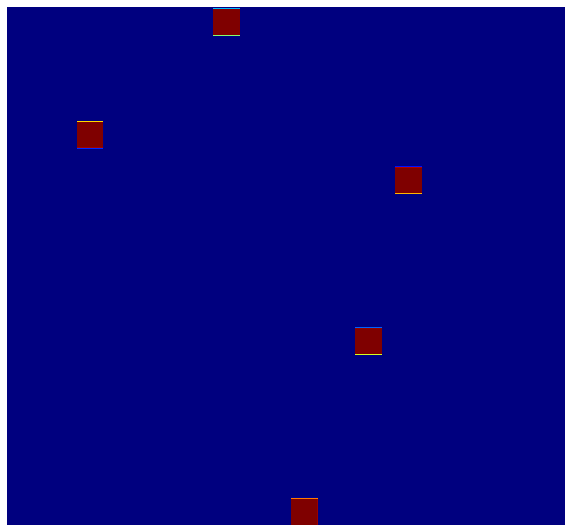

In [224]:

if config['georreferenced_save'] == True:
    visual_roi_mask = np.zeros_like(false_positive_mask)

    if config['site'] == 'MS':
        lims = manager.dataset.previewLims0
        visual_roi_mask[lims[0]:lims[1], lims[2]:lims[3]] = 1

    if config['site'] == 'PI':
        lims = manager.dataset.previewLims0
        visual_roi_mask[lims[0]:lims[1], lims[2]:lims[3]] = 1

        lims = manager.dataset.previewLims3
        visual_roi_mask[lims[0]:lims[1], lims[2]:lims[3]] = 1

        lims = manager.dataset.previewLims4
        visual_roi_mask[lims[0]:lims[1], lims[2]:lims[3]] = 1

    lims = manager.dataset.previewLims1
    visual_roi_mask[lims[0]:lims[1], lims[2]:lims[3]] = 1

    lims = manager.dataset.previewLims2
    visual_roi_mask[lims[0]:lims[1], lims[2]:lims[3]] = 1

    print(visual_roi_mask.shape)
    # visual_roi_mask_pad = rasterTools.padForGeorreferencingPA(visual_roi_mask)


    fig, ax = plt.subplots(figsize=(10,10))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(visual_roi_mask, cmap='jet')
    plt.axis('off')

    produced_im_path = 'D:/Jorge/deforestation_uncertainty/georreferenced/{}_visual_roi_georreferenced.tif'.format(
        manager.dataset.site
    )
    rasterTools.GeoReference_Raster_from_Source_data(original_im_path, 
                    np.expand_dims(visual_roi_mask, axis=0).astype(np.float32), produced_im_path, bands = 1,
                    nodata=-1)

In [223]:
print(previewLims0)

print(previewLims3)

print(previewLims4)

print(manager.dataset.previewLims1)

print(manager.dataset.previewLims2)

[ 6000  7000 14500 15500]
[12000 13000 13000 14000]
[4300 5300 2600 3600]
[18355 19355 10600 11600]
[ 100 1100 7700 8700]
